In [ ]:
!pip install optuna

In [36]:

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread


import collections
import cv2
import os
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import MinMaxScaler
import zipfile
import optuna

In [4]:
path = "D:\Documents\Downloads\Total\Total\Blinks"
image_path_list = os.listdir(path)
image_names = [re.sub('m.png|.png', '', img) for img in image_path_list if 'm.png' not in img]
mask_names = [re.sub('m.png|.png', '', img) for img in image_path_list if 'm.png' in img]
intersection = set(image_names).intersection(mask_names)

uniq_img_names = list(set(intersection))
print(len(uniq_img_names), '- Количество пар фотографий/ масок')


15417 - Количество пар фотографий/ масок


In [ ]:
def load_image(name, output=False):
    img = cv2.imread(path + '/' + name + '.png')
    return img

def load_mask(name, output=False):
    img_path = path + '\\' + name + 'm.png'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return np.array(img).reshape(img.shape[0], img.shape[1], 1)


def display(display_list, title_list=['Input Image', 'True Mask', 'Predicted Mask']):
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

In [ ]:
def print_cluster(result, cluster_tag):
    result_copy = np.zeros_like(result)
    slice_img = np.where(result == cluster_tag, 1, 0)
    result_copy[..., :] = slice_img[..., np.newaxis]
    return result_copy


def get_IoU_for_slice(slice_, mask):
    intersection = np.logical_and(slice_, mask)
    union = np.logical_or(slice_, mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


def get_IoU(slices):
    max_iou = np.max(slices)
    max_iou_index = np.argmax(slices)
    return max_iou, max_iou_index


def accuracy_IoU_scorer(result, mask):
    metrics_iou = []
    unique_tags = np.unique(result)
    for tag in unique_tags:
        result_copy = np.zeros_like(result)
        slice_img = np.where(result == tag, 1, 0)
        result_copy[..., :] = slice_img[..., np.newaxis]
        metrics_iou.append(get_IoU_for_slice(result_copy, mask))

    accuracy, cluster_ind = get_IoU(metrics_iou)
    slice_ = print_cluster(result, unique_tags[cluster_ind])
    return accuracy, slice_

In [ ]:
def dbscan(data, eps=0.01, min_samples=6, metric='euclidean'):
    print(f"Начало выполнения DBSCAN с параметрами eps={eps}, min_samples={min_samples}")
    
    db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, n_jobs=-1).fit(data)
    labels = db.labels_

    n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print("Оцененное количество кластеров: %d" % n_clusters)
    print("Оцененное количество выбросов: %d" % n_noise)

    labeled_img = labels.reshape(200, 200)

    return labeled_img


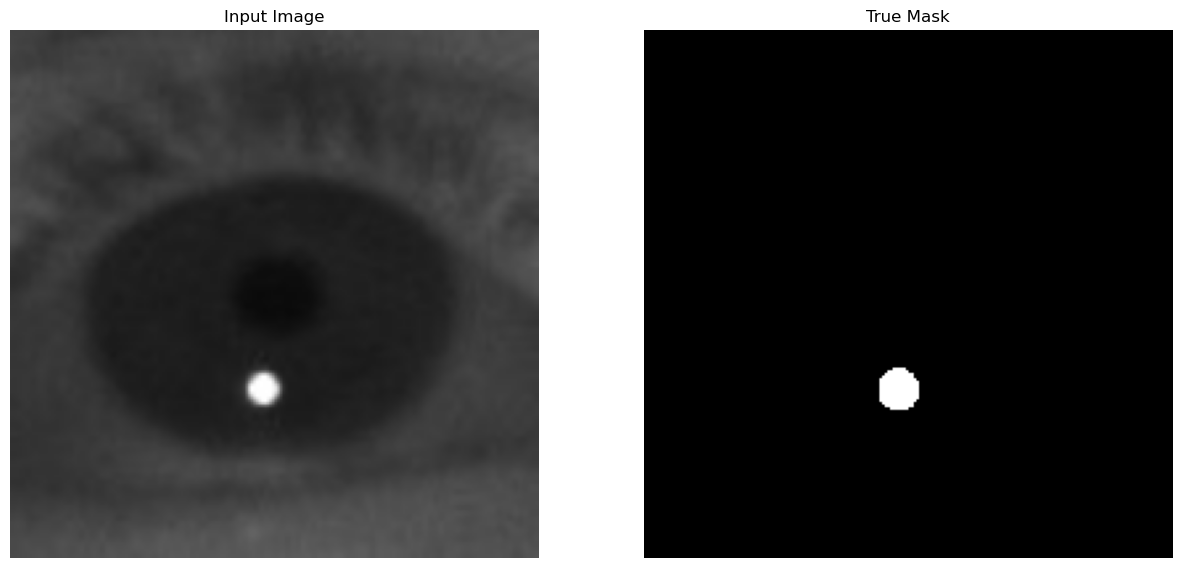

In [5]:
img = cv2.imread(path+'/1_Left_1.png')
mask = cv2.imread(path+'/1_Left_1m.png')
display([img,mask], ['Input Image','True Mask'])

In [6]:
n = 10
images = np.array([load_image(img) for img in tqdm(uniq_img_names[:n])])
masks = np.array([load_mask(img) for img in tqdm(uniq_img_names[:n])])

100%|██████████| 10/10 [00:00<00:00, 198.34it/s]


In [9]:
def objective(trial):
    eps = trial.suggest_uniform('eps', 2.5, 6.5)
    min_samples = trial.suggest_int('min_samples', 200, 500)

    db = dbscan(img_3f,eps=eps, min_samples=min_samples)

    # Calculate accuracy using accuracy_IoU_scorer function
    accuracy, _ = accuracy_IoU_scorer(db, mask)
    
    return accuracy

for i in range(n):
    img_3f = images[i].reshape((-1, 3))
    mask=masks[i]
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)
    best_trial = study.best_trial
    optimal_eps = best_trial.params['eps']
    optimal_min_samples = best_trial.params['min_samples']
    bestParamDBscan = dbscan(img_3f, optimal_eps, optimal_min_samples)
    accuracy, slice_ = accuracy_IoU_scorer(bestParamDBscan, masks[i])
    print(accuracy)
    directory = 'out/images/imagesDBScan/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open('out/images/imagesDBScan.txt', "a") as f:
        f.write(uniq_img_names[i] + ' ' + str(accuracy) + ' ' + str(optimal_eps)+ ' ' + str(optimal_min_samples) + '\n')
        f.close()

    data_2d = slice_.reshape((-1, slice_.shape[-1]))
    np.savetxt('out/images/imagesDBScan/' + (uniq_img_names[i]) + '.txt', data_2d, delimiter=',')


    

[I 2023-06-29 03:04:38,802] A new study created in memory with name: no-name-ade55b92-ba3e-4526-897c-16fbc827d0cd
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.0579730527341775, 273


[I 2023-06-29 03:04:40,664] Trial 0 finished with value: 0.2372448979591837 and parameters: {'eps': 3.0579730527341775, 'min_samples': 273}. Best is trial 0 with value: 0.2372448979591837.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.379566518278682, 324


[I 2023-06-29 03:04:44,146] Trial 1 finished with value: 0.6865671641791045 and parameters: {'eps': 5.379566518278682, 'min_samples': 324}. Best is trial 1 with value: 0.6865671641791045.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.166385103487359, 347


[I 2023-06-29 03:04:46,980] Trial 2 finished with value: 0.6739130434782609 and parameters: {'eps': 4.166385103487359, 'min_samples': 347}. Best is trial 1 with value: 0.6865671641791045.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.331585279505907, 238


[I 2023-06-29 03:04:50,296] Trial 3 finished with value: 0.6716417910447762 and parameters: {'eps': 5.331585279505907, 'min_samples': 238}. Best is trial 1 with value: 0.6865671641791045.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.1961957377745973, 424


[I 2023-06-29 03:04:52,189] Trial 4 finished with value: 0.09740932642487046 and parameters: {'eps': 3.1961957377745973, 'min_samples': 424}. Best is trial 1 with value: 0.6865671641791045.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.472547237455604, 207


[I 2023-06-29 03:04:54,905] Trial 5 finished with value: 0.6888888888888889 and parameters: {'eps': 4.472547237455604, 'min_samples': 207}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.613035754980743, 445


[I 2023-06-29 03:04:57,545] Trial 6 finished with value: 0.5470588235294118 and parameters: {'eps': 3.613035754980743, 'min_samples': 445}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.380932523668703, 495


[I 2023-06-29 03:05:00,237] Trial 7 finished with value: 0.1437403400309119 and parameters: {'eps': 4.380932523668703, 'min_samples': 495}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.548314569971609, 381


[I 2023-06-29 03:05:02,890] Trial 8 finished with value: 0.6739130434782609 and parameters: {'eps': 3.548314569971609, 'min_samples': 381}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.143044579026347, 467


[I 2023-06-29 03:05:06,343] Trial 9 finished with value: 0.6865671641791045 and parameters: {'eps': 6.143044579026347, 'min_samples': 467}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.7953304719173433, 218


[I 2023-06-29 03:05:08,117] Trial 10 finished with value: 0.3240418118466899 and parameters: {'eps': 2.7953304719173433, 'min_samples': 218}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.212220372900848, 303


[I 2023-06-29 03:05:11,636] Trial 11 finished with value: 0.6716417910447762 and parameters: {'eps': 5.212220372900848, 'min_samples': 303}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.071670556343722, 330


[I 2023-06-29 03:05:14,286] Trial 12 finished with value: 0.6838235294117647 and parameters: {'eps': 5.071670556343722, 'min_samples': 330}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.974189629060452, 267


[I 2023-06-29 03:05:17,806] Trial 13 finished with value: 0.6716417910447762 and parameters: {'eps': 5.974189629060452, 'min_samples': 267}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.659545158294411, 203


[I 2023-06-29 03:05:20,582] Trial 14 finished with value: 0.6888888888888889 and parameters: {'eps': 4.659545158294411, 'min_samples': 203}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.629943634874116, 211


[I 2023-06-29 03:05:23,237] Trial 15 finished with value: 0.6888888888888889 and parameters: {'eps': 4.629943634874116, 'min_samples': 211}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.000563123411279, 257


[I 2023-06-29 03:05:25,841] Trial 16 finished with value: 0.6888888888888889 and parameters: {'eps': 4.000563123411279, 'min_samples': 257}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.559648054833669, 384


[I 2023-06-29 03:05:28,556] Trial 17 finished with value: 0.6739130434782609 and parameters: {'eps': 4.559648054833669, 'min_samples': 384}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.856920774185734, 202


[I 2023-06-29 03:05:31,140] Trial 18 finished with value: 0.6888888888888889 and parameters: {'eps': 4.856920774185734, 'min_samples': 202}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.054709826665417, 301


[I 2023-06-29 03:05:33,790] Trial 19 finished with value: 0.6838235294117647 and parameters: {'eps': 4.054709826665417, 'min_samples': 301}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.5160035844177138, 239


[I 2023-06-29 03:05:35,452] Trial 20 finished with value: 0.29153605015673983 and parameters: {'eps': 2.5160035844177138, 'min_samples': 239}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.759464746840252, 212


[I 2023-06-29 03:05:38,041] Trial 21 finished with value: 0.6888888888888889 and parameters: {'eps': 4.759464746840252, 'min_samples': 212}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.52569525752689, 201


[I 2023-06-29 03:05:40,722] Trial 22 finished with value: 0.6888888888888889 and parameters: {'eps': 4.52569525752689, 'min_samples': 201}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.835611496514231, 240


[I 2023-06-29 03:05:43,351] Trial 23 finished with value: 0.6888888888888889 and parameters: {'eps': 4.835611496514231, 'min_samples': 240}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.5852761085864255, 291


[I 2023-06-29 03:05:46,780] Trial 24 finished with value: 0.6716417910447762 and parameters: {'eps': 5.5852761085864255, 'min_samples': 291}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.476025418686672, 229


[I 2023-06-29 03:05:50,240] Trial 25 finished with value: 0.6716417910447762 and parameters: {'eps': 6.476025418686672, 'min_samples': 229}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.9664606706048895, 253


[I 2023-06-29 03:05:52,927] Trial 26 finished with value: 0.6888888888888889 and parameters: {'eps': 4.9664606706048895, 'min_samples': 253}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.560177222253669, 277


[I 2023-06-29 03:05:55,548] Trial 27 finished with value: 0.6888888888888889 and parameters: {'eps': 4.560177222253669, 'min_samples': 277}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.268463301996238, 221


[I 2023-06-29 03:05:58,142] Trial 28 finished with value: 0.6888888888888889 and parameters: {'eps': 4.268463301996238, 'min_samples': 221}. Best is trial 5 with value: 0.6888888888888889.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.765750421978287, 280


[I 2023-06-29 03:06:00,760] Trial 29 finished with value: 0.6888888888888889 and parameters: {'eps': 4.765750421978287, 'min_samples': 280}. Best is trial 5 with value: 0.6888888888888889.


start DBSCAN with 4.472547237455604, 207
0.6888888888888889


[I 2023-06-29 03:06:03,607] A new study created in memory with name: no-name-b9c9e70b-0e10-4b9b-8b3e-2ebb85b99847
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.9577841180805877, 434


[I 2023-06-29 03:06:05,981] Trial 0 finished with value: 0.241869918699187 and parameters: {'eps': 3.9577841180805877, 'min_samples': 434}. Best is trial 0 with value: 0.241869918699187.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.613308161645907, 318


[I 2023-06-29 03:06:08,713] Trial 1 finished with value: 0.4872881355932203 and parameters: {'eps': 5.613308161645907, 'min_samples': 318}. Best is trial 1 with value: 0.4872881355932203.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.9901501141483555, 303


[I 2023-06-29 03:06:11,073] Trial 2 finished with value: 0.32054794520547947 and parameters: {'eps': 3.9901501141483555, 'min_samples': 303}. Best is trial 1 with value: 0.4872881355932203.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.776937552188619, 294


[I 2023-06-29 03:06:13,333] Trial 3 finished with value: 0.32054794520547947 and parameters: {'eps': 3.776937552188619, 'min_samples': 294}. Best is trial 1 with value: 0.4872881355932203.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.369272604564149, 465


[I 2023-06-29 03:06:15,649] Trial 4 finished with value: 0.21099290780141844 and parameters: {'eps': 4.369272604564149, 'min_samples': 465}. Best is trial 1 with value: 0.4872881355932203.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.7356221358036565, 298


[I 2023-06-29 03:06:18,603] Trial 5 finished with value: 0.5253456221198156 and parameters: {'eps': 5.7356221358036565, 'min_samples': 298}. Best is trial 5 with value: 0.5253456221198156.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.077505937327859, 338


[I 2023-06-29 03:06:21,028] Trial 6 finished with value: 0.241869918699187 and parameters: {'eps': 5.077505937327859, 'min_samples': 338}. Best is trial 5 with value: 0.5253456221198156.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.880407614892906, 263


[I 2023-06-29 03:06:23,432] Trial 7 finished with value: 0.32054794520547947 and parameters: {'eps': 4.880407614892906, 'min_samples': 263}. Best is trial 5 with value: 0.5253456221198156.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.669196743275522, 282


[I 2023-06-29 03:06:25,795] Trial 8 finished with value: 0.32054794520547947 and parameters: {'eps': 4.669196743275522, 'min_samples': 282}. Best is trial 5 with value: 0.5253456221198156.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.413188452791221, 320


[I 2023-06-29 03:06:28,199] Trial 9 finished with value: 0.2635135135135135 and parameters: {'eps': 4.413188452791221, 'min_samples': 320}. Best is trial 5 with value: 0.5253456221198156.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.219061325040249, 202


[I 2023-06-29 03:06:31,069] Trial 10 finished with value: 0.5507246376811594 and parameters: {'eps': 6.219061325040249, 'min_samples': 202}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.4653745844644135, 209


[I 2023-06-29 03:06:33,956] Trial 11 finished with value: 0.5507246376811594 and parameters: {'eps': 6.4653745844644135, 'min_samples': 209}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.1449430318811755, 200


[I 2023-06-29 03:06:36,843] Trial 12 finished with value: 0.5507246376811594 and parameters: {'eps': 6.1449430318811755, 'min_samples': 200}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.499558999756471, 205


[I 2023-06-29 03:06:39,714] Trial 13 finished with value: 0.5507246376811594 and parameters: {'eps': 6.499558999756471, 'min_samples': 205}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.6332859424597053, 394


[I 2023-06-29 03:06:41,131] Trial 14 finished with value: 0.12615384615384614 and parameters: {'eps': 2.6332859424597053, 'min_samples': 394}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.492505005746228, 240


[I 2023-06-29 03:06:43,975] Trial 15 finished with value: 0.5253456221198156 and parameters: {'eps': 6.492505005746228, 'min_samples': 240}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.8382160061001365, 236


[I 2023-06-29 03:06:46,819] Trial 16 finished with value: 0.5253456221198156 and parameters: {'eps': 5.8382160061001365, 'min_samples': 236}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.234561696353893, 374


[I 2023-06-29 03:06:49,688] Trial 17 finished with value: 0.452755905511811 and parameters: {'eps': 5.234561696353893, 'min_samples': 374}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.101718088357359, 230


[I 2023-06-29 03:06:52,491] Trial 18 finished with value: 0.5253456221198156 and parameters: {'eps': 6.101718088357359, 'min_samples': 230}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.115772938122053, 261


[I 2023-06-29 03:06:55,336] Trial 19 finished with value: 0.5253456221198156 and parameters: {'eps': 6.115772938122053, 'min_samples': 261}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.438311950481202, 201


[I 2023-06-29 03:06:58,122] Trial 20 finished with value: 0.5507246376811594 and parameters: {'eps': 5.438311950481202, 'min_samples': 201}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.0788643425470195, 201


[I 2023-06-29 03:07:01,007] Trial 21 finished with value: 0.5507246376811594 and parameters: {'eps': 6.0788643425470195, 'min_samples': 201}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.491358550169022, 229


[I 2023-06-29 03:07:03,978] Trial 22 finished with value: 0.5253456221198156 and parameters: {'eps': 6.491358550169022, 'min_samples': 229}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.982040653813148, 269


[I 2023-06-29 03:07:06,897] Trial 23 finished with value: 0.5253456221198156 and parameters: {'eps': 5.982040653813148, 'min_samples': 269}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.3416052368957505, 219


[I 2023-06-29 03:07:09,714] Trial 24 finished with value: 0.5507246376811594 and parameters: {'eps': 5.3416052368957505, 'min_samples': 219}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.651850037151036, 248


[I 2023-06-29 03:07:12,616] Trial 25 finished with value: 0.5253456221198156 and parameters: {'eps': 5.651850037151036, 'min_samples': 248}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.316646923549132, 489


[I 2023-06-29 03:07:15,491] Trial 26 finished with value: 0.452755905511811 and parameters: {'eps': 6.316646923549132, 'min_samples': 489}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.195322799346763, 216


[I 2023-06-29 03:07:18,496] Trial 27 finished with value: 0.5507246376811594 and parameters: {'eps': 6.195322799346763, 'min_samples': 216}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.824279740848654, 254


[I 2023-06-29 03:07:21,381] Trial 28 finished with value: 0.5253456221198156 and parameters: {'eps': 5.824279740848654, 'min_samples': 254}. Best is trial 10 with value: 0.5507246376811594.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.265385471016835, 421


[I 2023-06-29 03:07:24,233] Trial 29 finished with value: 0.452755905511811 and parameters: {'eps': 6.265385471016835, 'min_samples': 421}. Best is trial 10 with value: 0.5507246376811594.


start DBSCAN with 6.219061325040249, 202


[I 2023-06-29 03:07:27,207] A new study created in memory with name: no-name-77ca4c91-ac3a-4ef8-9394-809a184af9d6


0.5507246376811594
start DBSCAN with 4.615642103618885, 466


C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)
[I 2023-06-29 03:07:29,440] Trial 0 finished with value: 0.1549079754601227 and parameters: {'eps': 4.615642103618885, 'min_samples': 466}. Best is trial 0 with value: 0.1549079754601227.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.061171457299415, 242


[I 2023-06-29 03:07:31,782] Trial 1 finished with value: 0.22075055187637968 and parameters: {'eps': 4.061171457299415, 'min_samples': 242}. Best is trial 1 with value: 0.22075055187637968.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.5179442314970166, 364


[I 2023-06-29 03:07:33,349] Trial 2 finished with value: 0.11403508771929824 and parameters: {'eps': 2.5179442314970166, 'min_samples': 364}. Best is trial 1 with value: 0.22075055187637968.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.44908463946811, 441


[I 2023-06-29 03:07:36,152] Trial 3 finished with value: 0.28735632183908044 and parameters: {'eps': 5.44908463946811, 'min_samples': 441}. Best is trial 3 with value: 0.28735632183908044.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.957370847247511, 381


[I 2023-06-29 03:07:38,516] Trial 4 finished with value: 0.1813285457809695 and parameters: {'eps': 3.957370847247511, 'min_samples': 381}. Best is trial 3 with value: 0.28735632183908044.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.261626035463886, 491


[I 2023-06-29 03:07:41,401] Trial 5 finished with value: 0.28735632183908044 and parameters: {'eps': 5.261626035463886, 'min_samples': 491}. Best is trial 3 with value: 0.28735632183908044.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.3100355863737674, 213


[I 2023-06-29 03:07:42,929] Trial 6 finished with value: 0.14285714285714285 and parameters: {'eps': 3.3100355863737674, 'min_samples': 213}. Best is trial 3 with value: 0.28735632183908044.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.100973260882323, 213


[I 2023-06-29 03:07:45,293] Trial 7 finished with value: 0.2617801047120419 and parameters: {'eps': 4.100973260882323, 'min_samples': 213}. Best is trial 3 with value: 0.28735632183908044.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.76946945850944, 262


[I 2023-06-29 03:07:48,164] Trial 8 finished with value: 0.3508771929824561 and parameters: {'eps': 5.76946945850944, 'min_samples': 262}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.08432854993332, 484


[I 2023-06-29 03:07:50,419] Trial 9 finished with value: 0.0890652557319224 and parameters: {'eps': 5.08432854993332, 'min_samples': 484}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.427116670328718, 292


[I 2023-06-29 03:07:53,239] Trial 10 finished with value: 0.3508771929824561 and parameters: {'eps': 6.427116670328718, 'min_samples': 292}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.38902507080199, 296


[I 2023-06-29 03:07:56,016] Trial 11 finished with value: 0.3508771929824561 and parameters: {'eps': 6.38902507080199, 'min_samples': 296}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.4703273377745925, 297


[I 2023-06-29 03:07:58,827] Trial 12 finished with value: 0.3508771929824561 and parameters: {'eps': 6.4703273377745925, 'min_samples': 297}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.814700034528372, 293


[I 2023-06-29 03:08:01,693] Trial 13 finished with value: 0.3508771929824561 and parameters: {'eps': 5.814700034528372, 'min_samples': 293}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.960187463059595, 267


[I 2023-06-29 03:08:04,451] Trial 14 finished with value: 0.3508771929824561 and parameters: {'eps': 5.960187463059595, 'min_samples': 267}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.980327629704215, 329


[I 2023-06-29 03:08:07,261] Trial 15 finished with value: 0.33557046979865773 and parameters: {'eps': 5.980327629704215, 'min_samples': 329}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.4478528622919695, 409


[I 2023-06-29 03:08:10,102] Trial 16 finished with value: 0.28735632183908044 and parameters: {'eps': 6.4478528622919695, 'min_samples': 409}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.690786288462528, 330


[I 2023-06-29 03:08:13,104] Trial 17 finished with value: 0.33557046979865773 and parameters: {'eps': 5.690786288462528, 'min_samples': 330}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.967730104339581, 253


[I 2023-06-29 03:08:15,508] Trial 18 finished with value: 0.22075055187637968 and parameters: {'eps': 4.967730104339581, 'min_samples': 253}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.530048850512603, 318


[I 2023-06-29 03:08:18,423] Trial 19 finished with value: 0.33557046979865773 and parameters: {'eps': 5.530048850512603, 'min_samples': 318}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.02181840597136, 269


[I 2023-06-29 03:08:21,288] Trial 20 finished with value: 0.3508771929824561 and parameters: {'eps': 6.02181840597136, 'min_samples': 269}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.46185471870823, 293


[I 2023-06-29 03:08:24,133] Trial 21 finished with value: 0.3508771929824561 and parameters: {'eps': 6.46185471870823, 'min_samples': 293}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.155297380659981, 231


[I 2023-06-29 03:08:26,971] Trial 22 finished with value: 0.3508771929824561 and parameters: {'eps': 6.155297380659981, 'min_samples': 231}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.181985101635606, 272


[I 2023-06-29 03:08:29,808] Trial 23 finished with value: 0.3508771929824561 and parameters: {'eps': 6.181985101635606, 'min_samples': 272}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.674069275273589, 349


[I 2023-06-29 03:08:32,669] Trial 24 finished with value: 0.33557046979865773 and parameters: {'eps': 5.674069275273589, 'min_samples': 349}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.207686683175762, 301


[I 2023-06-29 03:08:35,419] Trial 25 finished with value: 0.33557046979865773 and parameters: {'eps': 6.207686683175762, 'min_samples': 301}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.751121228486653, 350


[I 2023-06-29 03:08:38,183] Trial 26 finished with value: 0.33557046979865773 and parameters: {'eps': 5.751121228486653, 'min_samples': 350}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.392057923007958, 237


[I 2023-06-29 03:08:41,086] Trial 27 finished with value: 0.3508771929824561 and parameters: {'eps': 5.392057923007958, 'min_samples': 237}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.333063627427044, 315


[I 2023-06-29 03:08:43,932] Trial 28 finished with value: 0.33557046979865773 and parameters: {'eps': 6.333063627427044, 'min_samples': 315}. Best is trial 8 with value: 0.3508771929824561.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.916118421748101, 278


[I 2023-06-29 03:08:46,745] Trial 29 finished with value: 0.3508771929824561 and parameters: {'eps': 5.916118421748101, 'min_samples': 278}. Best is trial 8 with value: 0.3508771929824561.


start DBSCAN with 5.76946945850944, 262
0.3508771929824561


[I 2023-06-29 03:08:49,656] A new study created in memory with name: no-name-167648a6-b66c-45a7-b543-85a9ccb6b8fd
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.0613527556285085, 350


[I 2023-06-29 03:08:52,356] Trial 0 finished with value: 0.43157894736842106 and parameters: {'eps': 4.0613527556285085, 'min_samples': 350}. Best is trial 0 with value: 0.43157894736842106.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.808852045496804, 240


[I 2023-06-29 03:08:55,060] Trial 1 finished with value: 0.47126436781609193 and parameters: {'eps': 4.808852045496804, 'min_samples': 240}. Best is trial 1 with value: 0.47126436781609193.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.1601526818777, 255


[I 2023-06-29 03:08:57,823] Trial 2 finished with value: 0.47126436781609193 and parameters: {'eps': 4.1601526818777, 'min_samples': 255}. Best is trial 1 with value: 0.47126436781609193.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.851922178889408, 459


[I 2023-06-29 03:09:00,531] Trial 3 finished with value: 0.36283185840707965 and parameters: {'eps': 3.851922178889408, 'min_samples': 459}. Best is trial 1 with value: 0.47126436781609193.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.8880128086344414, 212


[I 2023-06-29 03:09:03,128] Trial 4 finished with value: 0.47126436781609193 and parameters: {'eps': 3.8880128086344414, 'min_samples': 212}. Best is trial 1 with value: 0.47126436781609193.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.7963425702221985, 360


[I 2023-06-29 03:09:05,838] Trial 5 finished with value: 0.43157894736842106 and parameters: {'eps': 3.7963425702221985, 'min_samples': 360}. Best is trial 1 with value: 0.47126436781609193.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.835581640553583, 305


[I 2023-06-29 03:09:08,533] Trial 6 finished with value: 0.47126436781609193 and parameters: {'eps': 4.835581640553583, 'min_samples': 305}. Best is trial 1 with value: 0.47126436781609193.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.883019853679813, 261


[I 2023-06-29 03:09:12,009] Trial 7 finished with value: 0.5633802816901409 and parameters: {'eps': 5.883019853679813, 'min_samples': 261}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.943205732914408, 248


[I 2023-06-29 03:09:15,505] Trial 8 finished with value: 0.5633802816901409 and parameters: {'eps': 5.943205732914408, 'min_samples': 248}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.657344271927144, 390


[I 2023-06-29 03:09:19,002] Trial 9 finished with value: 0.5063291139240507 and parameters: {'eps': 5.657344271927144, 'min_samples': 390}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.458243741481776, 304


[I 2023-06-29 03:09:22,591] Trial 10 finished with value: 0.5633802816901409 and parameters: {'eps': 6.458243741481776, 'min_samples': 304}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.8727451098027417, 281


[I 2023-06-29 03:09:24,429] Trial 11 finished with value: 0.22162162162162163 and parameters: {'eps': 2.8727451098027417, 'min_samples': 281}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.423088611625468, 212


[I 2023-06-29 03:09:27,970] Trial 12 finished with value: 0.5633802816901409 and parameters: {'eps': 6.423088611625468, 'min_samples': 212}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.6526615935951385, 496


[I 2023-06-29 03:09:31,535] Trial 13 finished with value: 0.5063291139240507 and parameters: {'eps': 5.6526615935951385, 'min_samples': 496}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.785275748863594, 263


[I 2023-06-29 03:09:35,040] Trial 14 finished with value: 0.5633802816901409 and parameters: {'eps': 5.785275748863594, 'min_samples': 263}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.254155692754968, 321


[I 2023-06-29 03:09:38,572] Trial 15 finished with value: 0.5633802816901409 and parameters: {'eps': 5.254155692754968, 'min_samples': 321}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.0369318185412, 202


[I 2023-06-29 03:09:42,144] Trial 16 finished with value: 0.5633802816901409 and parameters: {'eps': 6.0369318185412, 'min_samples': 202}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.3004895024490155, 239


[I 2023-06-29 03:09:45,670] Trial 17 finished with value: 0.5633802816901409 and parameters: {'eps': 5.3004895024490155, 'min_samples': 239}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.073448690772822, 411


[I 2023-06-29 03:09:49,188] Trial 18 finished with value: 0.5063291139240507 and parameters: {'eps': 6.073448690772822, 'min_samples': 411}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.161331675629488, 285


[I 2023-06-29 03:09:51,799] Trial 19 finished with value: 0.47126436781609193 and parameters: {'eps': 5.161331675629488, 'min_samples': 285}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.146026218061476, 336


[I 2023-06-29 03:09:55,320] Trial 20 finished with value: 0.5633802816901409 and parameters: {'eps': 6.146026218061476, 'min_samples': 336}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.383607525590198, 297


[I 2023-06-29 03:09:58,869] Trial 21 finished with value: 0.5633802816901409 and parameters: {'eps': 6.383607525590198, 'min_samples': 297}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.492350202067925, 273


[I 2023-06-29 03:10:02,582] Trial 22 finished with value: 0.5633802816901409 and parameters: {'eps': 6.492350202067925, 'min_samples': 273}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.822807438145548, 237


[I 2023-06-29 03:10:06,511] Trial 23 finished with value: 0.5633802816901409 and parameters: {'eps': 5.822807438145548, 'min_samples': 237}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.15285799035839, 326


[I 2023-06-29 03:10:10,064] Trial 24 finished with value: 0.5633802816901409 and parameters: {'eps': 6.15285799035839, 'min_samples': 326}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.5139800786370445, 374


[I 2023-06-29 03:10:13,441] Trial 25 finished with value: 0.5063291139240507 and parameters: {'eps': 5.5139800786370445, 'min_samples': 374}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.935103642836015, 306


[I 2023-06-29 03:10:17,067] Trial 26 finished with value: 0.5633802816901409 and parameters: {'eps': 5.935103642836015, 'min_samples': 306}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.245870650071683, 250


[I 2023-06-29 03:10:20,629] Trial 27 finished with value: 0.5633802816901409 and parameters: {'eps': 6.245870650071683, 'min_samples': 250}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.487721178256145, 221


[I 2023-06-29 03:10:24,216] Trial 28 finished with value: 0.5633802816901409 and parameters: {'eps': 5.487721178256145, 'min_samples': 221}. Best is trial 7 with value: 0.5633802816901409.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.8560409056147, 341


[I 2023-06-29 03:10:27,715] Trial 29 finished with value: 0.5633802816901409 and parameters: {'eps': 5.8560409056147, 'min_samples': 341}. Best is trial 7 with value: 0.5633802816901409.


start DBSCAN with 5.883019853679813, 261


[I 2023-06-29 03:10:31,407] A new study created in memory with name: no-name-d2571879-5b71-4c43-8e2c-612ff9402802


0.5633802816901409


C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.522707119127527, 379


[I 2023-06-29 03:10:33,944] Trial 0 finished with value: 0.07893020221787345 and parameters: {'eps': 4.522707119127527, 'min_samples': 379}. Best is trial 0 with value: 0.07893020221787345.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.2462256775983, 377


[I 2023-06-29 03:10:37,263] Trial 1 finished with value: 0.15036496350364964 and parameters: {'eps': 6.2462256775983, 'min_samples': 377}. Best is trial 1 with value: 0.15036496350364964.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.000480393757326, 243


[I 2023-06-29 03:10:39,759] Trial 2 finished with value: 0.159375 and parameters: {'eps': 5.000480393757326, 'min_samples': 243}. Best is trial 2 with value: 0.159375.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.2018569966697825, 473


[I 2023-06-29 03:10:41,498] Trial 3 finished with value: 0.04889228418640183 and parameters: {'eps': 3.2018569966697825, 'min_samples': 473}. Best is trial 2 with value: 0.159375.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.0702232037484425, 410


[I 2023-06-29 03:10:43,960] Trial 4 finished with value: 0.07610062893081761 and parameters: {'eps': 5.0702232037484425, 'min_samples': 410}. Best is trial 2 with value: 0.159375.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.611299067276322, 344


[I 2023-06-29 03:10:46,412] Trial 5 finished with value: 0.11066398390342053 and parameters: {'eps': 4.611299067276322, 'min_samples': 344}. Best is trial 2 with value: 0.159375.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.6013640984018283, 380


[I 2023-06-29 03:10:48,144] Trial 6 finished with value: 0.052872606161532054 and parameters: {'eps': 2.6013640984018283, 'min_samples': 380}. Best is trial 2 with value: 0.159375.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.893853901851919, 292


[I 2023-06-29 03:10:51,414] Trial 7 finished with value: 0.1807909604519774 and parameters: {'eps': 5.893853901851919, 'min_samples': 292}. Best is trial 7 with value: 0.1807909604519774.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.2921425930414836, 455


[I 2023-06-29 03:10:53,105] Trial 8 finished with value: 0.04889228418640183 and parameters: {'eps': 3.2921425930414836, 'min_samples': 455}. Best is trial 7 with value: 0.1807909604519774.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.344150331539306, 266


[I 2023-06-29 03:10:55,572] Trial 9 finished with value: 0.14051841746248295 and parameters: {'eps': 4.344150331539306, 'min_samples': 266}. Best is trial 7 with value: 0.1807909604519774.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.458961629767606, 305


[I 2023-06-29 03:10:58,780] Trial 10 finished with value: 0.1735241502683363 and parameters: {'eps': 6.458961629767606, 'min_samples': 305}. Best is trial 7 with value: 0.1807909604519774.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.466000892782989, 299


[I 2023-06-29 03:11:02,000] Trial 11 finished with value: 0.1807909604519774 and parameters: {'eps': 6.466000892782989, 'min_samples': 299}. Best is trial 7 with value: 0.1807909604519774.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.973308738129994, 212


[I 2023-06-29 03:11:05,279] Trial 12 finished with value: 0.2100456621004566 and parameters: {'eps': 5.973308738129994, 'min_samples': 212}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.734309157088954, 206


[I 2023-06-29 03:11:08,557] Trial 13 finished with value: 0.2100456621004566 and parameters: {'eps': 5.734309157088954, 'min_samples': 206}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.709743877926562, 216


[I 2023-06-29 03:11:12,100] Trial 14 finished with value: 0.20305676855895197 and parameters: {'eps': 5.709743877926562, 'min_samples': 216}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.57868561733095, 230


[I 2023-06-29 03:11:15,487] Trial 15 finished with value: 0.20305676855895197 and parameters: {'eps': 5.57868561733095, 'min_samples': 230}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.889627820130491, 206


[I 2023-06-29 03:11:18,952] Trial 16 finished with value: 0.2100456621004566 and parameters: {'eps': 5.889627820130491, 'min_samples': 206}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.331164334266346, 257


[I 2023-06-29 03:11:22,450] Trial 17 finished with value: 0.19624217118997914 and parameters: {'eps': 5.331164334266346, 'min_samples': 257}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.069508969611961, 326


[I 2023-06-29 03:11:25,745] Trial 18 finished with value: 0.1735241502683363 and parameters: {'eps': 6.069508969611961, 'min_samples': 326}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.4893527066513945, 203


[I 2023-06-29 03:11:28,940] Trial 19 finished with value: 0.2100456621004566 and parameters: {'eps': 5.4893527066513945, 'min_samples': 203}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.9877488003245745, 274


[I 2023-06-29 03:11:32,184] Trial 20 finished with value: 0.1807909604519774 and parameters: {'eps': 5.9877488003245745, 'min_samples': 274}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.8681898274106885, 206


[I 2023-06-29 03:11:35,294] Trial 21 finished with value: 0.2100456621004566 and parameters: {'eps': 5.8681898274106885, 'min_samples': 206}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.192423909987926, 228


[I 2023-06-29 03:11:38,493] Trial 22 finished with value: 0.20305676855895197 and parameters: {'eps': 6.192423909987926, 'min_samples': 228}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.666304413782699, 200


[I 2023-06-29 03:11:41,734] Trial 23 finished with value: 0.2100456621004566 and parameters: {'eps': 5.666304413782699, 'min_samples': 200}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.303969900819074, 244


[I 2023-06-29 03:11:45,330] Trial 24 finished with value: 0.19624217118997914 and parameters: {'eps': 5.303969900819074, 'min_samples': 244}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.1254835177284095, 268


[I 2023-06-29 03:11:48,867] Trial 25 finished with value: 0.1900990099009901 and parameters: {'eps': 6.1254835177284095, 'min_samples': 268}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.482900527302269, 233


[I 2023-06-29 03:11:52,118] Trial 26 finished with value: 0.20305676855895197 and parameters: {'eps': 6.482900527302269, 'min_samples': 233}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.838685548988146, 249


[I 2023-06-29 03:11:55,358] Trial 27 finished with value: 0.19624217118997914 and parameters: {'eps': 5.838685548988146, 'min_samples': 249}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.496875758787752, 224


[I 2023-06-29 03:11:58,592] Trial 28 finished with value: 0.20305676855895197 and parameters: {'eps': 5.496875758787752, 'min_samples': 224}. Best is trial 12 with value: 0.2100456621004566.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.141007450073244, 325


[I 2023-06-29 03:12:01,760] Trial 29 finished with value: 0.1735241502683363 and parameters: {'eps': 6.141007450073244, 'min_samples': 325}. Best is trial 12 with value: 0.2100456621004566.


start DBSCAN with 5.973308738129994, 212
0.2100456621004566


[I 2023-06-29 03:12:05,198] A new study created in memory with name: no-name-9c489c5f-24e5-4fc7-a7e3-7159f16ad98b
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.497392661831924, 476


[I 2023-06-29 03:12:08,464] Trial 0 finished with value: 0.7857142857142857 and parameters: {'eps': 6.497392661831924, 'min_samples': 476}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.127580487129723, 282


[I 2023-06-29 03:12:11,036] Trial 1 finished with value: 0.7252747252747253 and parameters: {'eps': 5.127580487129723, 'min_samples': 282}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.828460901068963, 362


[I 2023-06-29 03:12:13,589] Trial 2 finished with value: 0.7252747252747253 and parameters: {'eps': 4.828460901068963, 'min_samples': 362}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.2907611764843674, 429


[I 2023-06-29 03:12:15,364] Trial 3 finished with value: 0.1976401179941003 and parameters: {'eps': 3.2907611764843674, 'min_samples': 429}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.271071546819028, 436


[I 2023-06-29 03:12:18,695] Trial 4 finished with value: 0.7857142857142857 and parameters: {'eps': 6.271071546819028, 'min_samples': 436}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.201044115002413, 381


[I 2023-06-29 03:12:22,099] Trial 5 finished with value: 0.7857142857142857 and parameters: {'eps': 6.201044115002413, 'min_samples': 381}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.384718142760713, 358


[I 2023-06-29 03:12:24,740] Trial 6 finished with value: 0.7252747252747253 and parameters: {'eps': 4.384718142760713, 'min_samples': 358}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.8209183018049586, 330


[I 2023-06-29 03:12:26,530] Trial 7 finished with value: 0.41509433962264153 and parameters: {'eps': 2.8209183018049586, 'min_samples': 330}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.5645316734492765, 469


[I 2023-06-29 03:12:28,198] Trial 8 finished with value: 0.14439655172413793 and parameters: {'eps': 2.5645316734492765, 'min_samples': 469}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.99056104395318, 354


[I 2023-06-29 03:12:29,994] Trial 9 finished with value: 0.41509433962264153 and parameters: {'eps': 2.99056104395318, 'min_samples': 354}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.619852229394848, 201


[I 2023-06-29 03:12:33,617] Trial 10 finished with value: 0.7738095238095238 and parameters: {'eps': 5.619852229394848, 'min_samples': 201}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.396068109389914, 489


[I 2023-06-29 03:12:37,012] Trial 11 finished with value: 0.7674418604651163 and parameters: {'eps': 6.396068109389914, 'min_samples': 489}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.290866334774291, 442


[I 2023-06-29 03:12:40,535] Trial 12 finished with value: 0.7857142857142857 and parameters: {'eps': 6.290866334774291, 'min_samples': 442}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.67722251540597, 414


[I 2023-06-29 03:12:44,005] Trial 13 finished with value: 0.7857142857142857 and parameters: {'eps': 5.67722251540597, 'min_samples': 414}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.46043392220232, 499


[I 2023-06-29 03:12:47,393] Trial 14 finished with value: 0.7674418604651163 and parameters: {'eps': 6.46043392220232, 'min_samples': 499}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.699921988014865, 447


[I 2023-06-29 03:12:50,942] Trial 15 finished with value: 0.7857142857142857 and parameters: {'eps': 5.699921988014865, 'min_samples': 447}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.9016394173983535, 399


[I 2023-06-29 03:12:54,150] Trial 16 finished with value: 0.7857142857142857 and parameters: {'eps': 5.9016394173983535, 'min_samples': 399}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.492104997052115, 297


[I 2023-06-29 03:12:57,424] Trial 17 finished with value: 0.7857142857142857 and parameters: {'eps': 6.492104997052115, 'min_samples': 297}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.1143973881924145, 462


[I 2023-06-29 03:12:59,892] Trial 18 finished with value: 0.7252747252747253 and parameters: {'eps': 5.1143973881924145, 'min_samples': 462}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.835694253060716, 404


[I 2023-06-29 03:13:03,103] Trial 19 finished with value: 0.7857142857142857 and parameters: {'eps': 5.835694253060716, 'min_samples': 404}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.211168538363875, 480


[I 2023-06-29 03:13:05,664] Trial 20 finished with value: 0.7252747252747253 and parameters: {'eps': 4.211168538363875, 'min_samples': 480}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.144685205121424, 390


[I 2023-06-29 03:13:08,896] Trial 21 finished with value: 0.7857142857142857 and parameters: {'eps': 6.144685205121424, 'min_samples': 390}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.017324054229946, 386


[I 2023-06-29 03:13:12,206] Trial 22 finished with value: 0.7857142857142857 and parameters: {'eps': 6.017324054229946, 'min_samples': 386}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.111792498353875, 423


[I 2023-06-29 03:13:15,452] Trial 23 finished with value: 0.7857142857142857 and parameters: {'eps': 6.111792498353875, 'min_samples': 423}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.427047627665326, 457


[I 2023-06-29 03:13:18,810] Trial 24 finished with value: 0.7857142857142857 and parameters: {'eps': 5.427047627665326, 'min_samples': 457}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.07045986747588, 322


[I 2023-06-29 03:13:22,204] Trial 25 finished with value: 0.7857142857142857 and parameters: {'eps': 6.07045986747588, 'min_samples': 322}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.482688282907389, 379


[I 2023-06-29 03:13:25,483] Trial 26 finished with value: 0.7857142857142857 and parameters: {'eps': 6.482688282907389, 'min_samples': 379}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.159294280451499, 217


[I 2023-06-29 03:13:29,079] Trial 27 finished with value: 0.7738095238095238 and parameters: {'eps': 6.159294280451499, 'min_samples': 217}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.473783446246294, 429


[I 2023-06-29 03:13:32,702] Trial 28 finished with value: 0.7857142857142857 and parameters: {'eps': 5.473783446246294, 'min_samples': 429}. Best is trial 0 with value: 0.7857142857142857.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.271928674072862, 259


[I 2023-06-29 03:13:35,995] Trial 29 finished with value: 0.7738095238095238 and parameters: {'eps': 5.271928674072862, 'min_samples': 259}. Best is trial 0 with value: 0.7857142857142857.


start DBSCAN with 6.497392661831924, 476


[I 2023-06-29 03:13:39,388] A new study created in memory with name: no-name-6fd01146-1e34-4a7d-a1b7-0f7f70187cc6


0.7857142857142857
start DBSCAN with 5.106952005220617, 382


C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)
[I 2023-06-29 03:13:41,936] Trial 0 finished with value: 0.11617312072892938 and parameters: {'eps': 5.106952005220617, 'min_samples': 382}. Best is trial 0 with value: 0.11617312072892938.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.551987323071516, 477


[I 2023-06-29 03:13:45,342] Trial 1 finished with value: 0.13010204081632654 and parameters: {'eps': 5.551987323071516, 'min_samples': 477}. Best is trial 1 with value: 0.13010204081632654.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.262364049958302, 385


[I 2023-06-29 03:13:48,736] Trial 2 finished with value: 0.15873015873015872 and parameters: {'eps': 6.262364049958302, 'min_samples': 385}. Best is trial 2 with value: 0.15873015873015872.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.555638832066437, 438


[I 2023-06-29 03:13:52,234] Trial 3 finished with value: 0.14367816091954022 and parameters: {'eps': 5.555638832066437, 'min_samples': 438}. Best is trial 2 with value: 0.15873015873015872.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.2927671137835226, 236


[I 2023-06-29 03:13:54,139] Trial 4 finished with value: 0.08762886597938144 and parameters: {'eps': 3.2927671137835226, 'min_samples': 236}. Best is trial 2 with value: 0.15873015873015872.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.7106987283847954, 344


[I 2023-06-29 03:13:56,012] Trial 5 finished with value: 0.02888781896966779 and parameters: {'eps': 2.7106987283847954, 'min_samples': 344}. Best is trial 2 with value: 0.15873015873015872.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.661148025885135, 437


[I 2023-06-29 03:13:59,310] Trial 6 finished with value: 0.14367816091954022 and parameters: {'eps': 5.661148025885135, 'min_samples': 437}. Best is trial 2 with value: 0.15873015873015872.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.200537661377547, 368


[I 2023-06-29 03:14:01,151] Trial 7 finished with value: 0.02645273200346921 and parameters: {'eps': 3.200537661377547, 'min_samples': 368}. Best is trial 2 with value: 0.15873015873015872.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.596713538329501, 331


[I 2023-06-29 03:14:03,677] Trial 8 finished with value: 0.13010204081632654 and parameters: {'eps': 4.596713538329501, 'min_samples': 331}. Best is trial 2 with value: 0.15873015873015872.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.633508188968158, 437


[I 2023-06-29 03:14:05,469] Trial 9 finished with value: 0.019256132946452124 and parameters: {'eps': 2.633508188968158, 'min_samples': 437}. Best is trial 2 with value: 0.15873015873015872.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.452330860451247, 265


[I 2023-06-29 03:14:08,873] Trial 10 finished with value: 0.21030042918454936 and parameters: {'eps': 6.452330860451247, 'min_samples': 265}. Best is trial 10 with value: 0.21030042918454936.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.432770325194471, 252


[I 2023-06-29 03:14:12,481] Trial 11 finished with value: 0.21030042918454936 and parameters: {'eps': 6.432770325194471, 'min_samples': 252}. Best is trial 10 with value: 0.21030042918454936.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.4599375789417515, 232


[I 2023-06-29 03:14:16,006] Trial 12 finished with value: 0.21030042918454936 and parameters: {'eps': 6.4599375789417515, 'min_samples': 232}. Best is trial 10 with value: 0.21030042918454936.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.469610109277515, 280


[I 2023-06-29 03:14:19,497] Trial 13 finished with value: 0.21030042918454936 and parameters: {'eps': 6.469610109277515, 'min_samples': 280}. Best is trial 10 with value: 0.21030042918454936.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.048654884594539, 201


[I 2023-06-29 03:14:22,971] Trial 14 finished with value: 0.2300469483568075 and parameters: {'eps': 6.048654884594539, 'min_samples': 201}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.969168362383392, 203


[I 2023-06-29 03:14:26,420] Trial 15 finished with value: 0.2300469483568075 and parameters: {'eps': 5.969168362383392, 'min_samples': 203}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.7130761506960335, 201


[I 2023-06-29 03:14:29,089] Trial 16 finished with value: 0.17857142857142858 and parameters: {'eps': 4.7130761506960335, 'min_samples': 201}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.003856713356145, 300


[I 2023-06-29 03:14:32,647] Trial 17 finished with value: 0.1984126984126984 and parameters: {'eps': 6.003856713356145, 'min_samples': 300}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.908096731235874, 201


[I 2023-06-29 03:14:36,184] Trial 18 finished with value: 0.2300469483568075 and parameters: {'eps': 5.908096731235874, 'min_samples': 201}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.1259096113431495, 312


[I 2023-06-29 03:14:38,824] Trial 19 finished with value: 0.13010204081632654 and parameters: {'eps': 5.1259096113431495, 'min_samples': 312}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.280009389390518, 232


[I 2023-06-29 03:14:41,563] Trial 20 finished with value: 0.17857142857142858 and parameters: {'eps': 4.280009389390518, 'min_samples': 232}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.047350996702407, 208


[I 2023-06-29 03:14:45,101] Trial 21 finished with value: 0.2300469483568075 and parameters: {'eps': 6.047350996702407, 'min_samples': 208}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.9554769144073525, 202


[I 2023-06-29 03:14:48,509] Trial 22 finished with value: 0.2300469483568075 and parameters: {'eps': 5.9554769144073525, 'min_samples': 202}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.800450131147805, 278


[I 2023-06-29 03:14:52,062] Trial 23 finished with value: 0.21030042918454936 and parameters: {'eps': 5.800450131147805, 'min_samples': 278}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.0515604654801685, 225


[I 2023-06-29 03:14:55,459] Trial 24 finished with value: 0.2300469483568075 and parameters: {'eps': 6.0515604654801685, 'min_samples': 225}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.428019138183957, 254


[I 2023-06-29 03:14:58,981] Trial 25 finished with value: 0.21030042918454936 and parameters: {'eps': 5.428019138183957, 'min_samples': 254}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.871694553398646, 296


[I 2023-06-29 03:15:02,487] Trial 26 finished with value: 0.1984126984126984 and parameters: {'eps': 5.871694553398646, 'min_samples': 296}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.154200407612211, 220


[I 2023-06-29 03:15:06,106] Trial 27 finished with value: 0.2300469483568075 and parameters: {'eps': 6.154200407612211, 'min_samples': 220}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.2932464427803705, 250


[I 2023-06-29 03:15:09,659] Trial 28 finished with value: 0.21030042918454936 and parameters: {'eps': 5.2932464427803705, 'min_samples': 250}. Best is trial 14 with value: 0.2300469483568075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.737715582640389, 217


[I 2023-06-29 03:15:13,169] Trial 29 finished with value: 0.2300469483568075 and parameters: {'eps': 5.737715582640389, 'min_samples': 217}. Best is trial 14 with value: 0.2300469483568075.


start DBSCAN with 6.048654884594539, 201


[I 2023-06-29 03:15:16,822] A new study created in memory with name: no-name-6c62dbe2-ca4c-4a57-932e-6f4a9bb30ace


0.2300469483568075


C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.91227349699207, 354


[I 2023-06-29 03:15:19,252] Trial 0 finished with value: 0.32967032967032966 and parameters: {'eps': 4.91227349699207, 'min_samples': 354}. Best is trial 0 with value: 0.32967032967032966.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.9130139746845285, 300


[I 2023-06-29 03:15:20,943] Trial 1 finished with value: 0.1273100616016427 and parameters: {'eps': 2.9130139746845285, 'min_samples': 300}. Best is trial 0 with value: 0.32967032967032966.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.1298605035861584, 219


[I 2023-06-29 03:15:22,589] Trial 2 finished with value: 0.1875 and parameters: {'eps': 3.1298605035861584, 'min_samples': 219}. Best is trial 0 with value: 0.32967032967032966.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.9399742921099254, 478


[I 2023-06-29 03:15:25,139] Trial 3 finished with value: 0.2830188679245283 and parameters: {'eps': 3.9399742921099254, 'min_samples': 478}. Best is trial 0 with value: 0.32967032967032966.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.835645046703301, 347


[I 2023-06-29 03:15:27,730] Trial 4 finished with value: 0.32967032967032966 and parameters: {'eps': 3.835645046703301, 'min_samples': 347}. Best is trial 0 with value: 0.32967032967032966.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.220879899475217, 228


[I 2023-06-29 03:15:30,915] Trial 5 finished with value: 0.4014084507042254 and parameters: {'eps': 6.220879899475217, 'min_samples': 228}. Best is trial 5 with value: 0.4014084507042254.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.196472008053137, 454


[I 2023-06-29 03:15:34,097] Trial 6 finished with value: 0.35365853658536583 and parameters: {'eps': 6.196472008053137, 'min_samples': 454}. Best is trial 5 with value: 0.4014084507042254.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.93988857867104, 260


[I 2023-06-29 03:15:37,510] Trial 7 finished with value: 0.4014084507042254 and parameters: {'eps': 5.93988857867104, 'min_samples': 260}. Best is trial 5 with value: 0.4014084507042254.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.4109024903099874, 247


[I 2023-06-29 03:15:39,214] Trial 8 finished with value: 0.16711590296495957 and parameters: {'eps': 3.4109024903099874, 'min_samples': 247}. Best is trial 5 with value: 0.4014084507042254.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.807213783229727, 351


[I 2023-06-29 03:15:42,418] Trial 9 finished with value: 0.38926174496644295 and parameters: {'eps': 5.807213783229727, 'min_samples': 351}. Best is trial 5 with value: 0.4014084507042254.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.4778819836861, 203


[I 2023-06-29 03:15:45,631] Trial 10 finished with value: 0.4253731343283582 and parameters: {'eps': 6.4778819836861, 'min_samples': 203}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.2832701652289575, 215


[I 2023-06-29 03:15:48,840] Trial 11 finished with value: 0.4014084507042254 and parameters: {'eps': 5.2832701652289575, 'min_samples': 215}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.353300911487287, 282


[I 2023-06-29 03:15:52,043] Trial 12 finished with value: 0.4014084507042254 and parameters: {'eps': 6.353300911487287, 'min_samples': 282}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.521593936262543, 209


[I 2023-06-29 03:15:55,269] Trial 13 finished with value: 0.4253731343283582 and parameters: {'eps': 5.521593936262543, 'min_samples': 209}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.464947618806886, 427


[I 2023-06-29 03:15:58,482] Trial 14 finished with value: 0.38926174496644295 and parameters: {'eps': 5.464947618806886, 'min_samples': 427}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.490833578565232, 308


[I 2023-06-29 03:16:01,610] Trial 15 finished with value: 0.4014084507042254 and parameters: {'eps': 6.490833578565232, 'min_samples': 308}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.643351315513762, 403


[I 2023-06-29 03:16:04,039] Trial 16 finished with value: 0.32967032967032966 and parameters: {'eps': 4.643351315513762, 'min_samples': 403}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.589184854281855, 208


[I 2023-06-29 03:16:07,188] Trial 17 finished with value: 0.4253731343283582 and parameters: {'eps': 5.589184854281855, 'min_samples': 208}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.082609241847844, 268


[I 2023-06-29 03:16:09,731] Trial 18 finished with value: 0.35365853658536583 and parameters: {'eps': 5.082609241847844, 'min_samples': 268}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.793962524580318, 320


[I 2023-06-29 03:16:12,877] Trial 19 finished with value: 0.38926174496644295 and parameters: {'eps': 5.793962524580318, 'min_samples': 320}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.360986181199242, 246


[I 2023-06-29 03:16:16,145] Trial 20 finished with value: 0.4014084507042254 and parameters: {'eps': 5.360986181199242, 'min_samples': 246}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.529681698590267, 208


[I 2023-06-29 03:16:19,354] Trial 21 finished with value: 0.4253731343283582 and parameters: {'eps': 5.529681698590267, 'min_samples': 208}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.95608367068102, 241


[I 2023-06-29 03:16:22,639] Trial 22 finished with value: 0.4014084507042254 and parameters: {'eps': 5.95608367068102, 'min_samples': 241}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.4796338779900156, 214


[I 2023-06-29 03:16:25,846] Trial 23 finished with value: 0.4014084507042254 and parameters: {'eps': 6.4796338779900156, 'min_samples': 214}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.611060225515031, 200


[I 2023-06-29 03:16:29,119] Trial 24 finished with value: 0.4253731343283582 and parameters: {'eps': 5.611060225515031, 'min_samples': 200}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.854814099748066, 276


[I 2023-06-29 03:16:31,587] Trial 25 finished with value: 0.35365853658536583 and parameters: {'eps': 4.854814099748066, 'min_samples': 276}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.108344162243513, 234


[I 2023-06-29 03:16:34,785] Trial 26 finished with value: 0.4014084507042254 and parameters: {'eps': 6.108344162243513, 'min_samples': 234}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.744409898606483, 202


[I 2023-06-29 03:16:38,076] Trial 27 finished with value: 0.4253731343283582 and parameters: {'eps': 5.744409898606483, 'min_samples': 202}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.241959922581948, 386


[I 2023-06-29 03:16:41,274] Trial 28 finished with value: 0.38926174496644295 and parameters: {'eps': 5.241959922581948, 'min_samples': 386}. Best is trial 10 with value: 0.4253731343283582.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.825054641076957, 286


[I 2023-06-29 03:16:43,743] Trial 29 finished with value: 0.35365853658536583 and parameters: {'eps': 4.825054641076957, 'min_samples': 286}. Best is trial 10 with value: 0.4253731343283582.


start DBSCAN with 6.4778819836861, 203


[I 2023-06-29 03:16:47,107] A new study created in memory with name: no-name-23a70b51-a640-425b-b481-a39617648d3c


0.4253731343283582


C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.548128735296014, 398


[I 2023-06-29 03:16:49,282] Trial 0 finished with value: 0.29936305732484075 and parameters: {'eps': 2.548128735296014, 'min_samples': 398}. Best is trial 0 with value: 0.29936305732484075.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.691848743630283, 465


[I 2023-06-29 03:16:52,497] Trial 1 finished with value: 0.5769230769230769 and parameters: {'eps': 4.691848743630283, 'min_samples': 465}. Best is trial 1 with value: 0.5769230769230769.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.766877084812414, 476


[I 2023-06-29 03:16:55,953] Trial 2 finished with value: 0.5769230769230769 and parameters: {'eps': 4.766877084812414, 'min_samples': 476}. Best is trial 1 with value: 0.5769230769230769.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.208777897393411, 442


[I 2023-06-29 03:17:00,324] Trial 3 finished with value: 0.5945945945945946 and parameters: {'eps': 6.208777897393411, 'min_samples': 442}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.661192585017227, 332


[I 2023-06-29 03:17:04,321] Trial 4 finished with value: 0.581081081081081 and parameters: {'eps': 5.661192585017227, 'min_samples': 332}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.2457774700123725, 345


[I 2023-06-29 03:17:08,835] Trial 5 finished with value: 0.581081081081081 and parameters: {'eps': 6.2457774700123725, 'min_samples': 345}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.09401441995732, 459


[I 2023-06-29 03:17:12,193] Trial 6 finished with value: 0.5769230769230769 and parameters: {'eps': 5.09401441995732, 'min_samples': 459}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.9791874625102768, 204


[I 2023-06-29 03:17:14,468] Trial 7 finished with value: 0.40350877192982454 and parameters: {'eps': 2.9791874625102768, 'min_samples': 204}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.10575471071988, 431


[I 2023-06-29 03:17:17,721] Trial 8 finished with value: 0.5769230769230769 and parameters: {'eps': 4.10575471071988, 'min_samples': 431}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.258344057289067, 224


[I 2023-06-29 03:17:19,980] Trial 9 finished with value: 0.40350877192982454 and parameters: {'eps': 3.258344057289067, 'min_samples': 224}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.4505232613991526, 284


[I 2023-06-29 03:17:24,062] Trial 10 finished with value: 0.581081081081081 and parameters: {'eps': 6.4505232613991526, 'min_samples': 284}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.777637460407984, 352


[I 2023-06-29 03:17:28,074] Trial 11 finished with value: 0.581081081081081 and parameters: {'eps': 5.777637460407984, 'min_samples': 352}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.670624749692485, 351


[I 2023-06-29 03:17:32,132] Trial 12 finished with value: 0.581081081081081 and parameters: {'eps': 5.670624749692485, 'min_samples': 351}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.634668838506032, 290


[I 2023-06-29 03:17:36,259] Trial 13 finished with value: 0.581081081081081 and parameters: {'eps': 5.634668838506032, 'min_samples': 290}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.385953067445694, 397


[I 2023-06-29 03:17:40,172] Trial 14 finished with value: 0.5945945945945946 and parameters: {'eps': 6.385953067445694, 'min_samples': 397}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.451583330833653, 404


[I 2023-06-29 03:17:44,104] Trial 15 finished with value: 0.5945945945945946 and parameters: {'eps': 6.451583330833653, 'min_samples': 404}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.047940158101626, 498


[I 2023-06-29 03:17:48,041] Trial 16 finished with value: 0.5945945945945946 and parameters: {'eps': 6.047940158101626, 'min_samples': 498}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.073047241381448, 397


[I 2023-06-29 03:17:51,192] Trial 17 finished with value: 0.5769230769230769 and parameters: {'eps': 5.073047241381448, 'min_samples': 397}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.07600141986173, 438


[I 2023-06-29 03:17:55,141] Trial 18 finished with value: 0.5945945945945946 and parameters: {'eps': 6.07600141986173, 'min_samples': 438}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.451413631001506, 382


[I 2023-06-29 03:17:59,339] Trial 19 finished with value: 0.5945945945945946 and parameters: {'eps': 6.451413631001506, 'min_samples': 382}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.216356499561415, 426


[I 2023-06-29 03:18:03,283] Trial 20 finished with value: 0.5945945945945946 and parameters: {'eps': 5.216356499561415, 'min_samples': 426}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.499553169985909, 382


[I 2023-06-29 03:18:07,441] Trial 21 finished with value: 0.5945945945945946 and parameters: {'eps': 6.499553169985909, 'min_samples': 382}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.042130454524944, 398


[I 2023-06-29 03:18:11,534] Trial 22 finished with value: 0.5945945945945946 and parameters: {'eps': 6.042130454524944, 'min_samples': 398}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.1092821843208345, 421


[I 2023-06-29 03:18:15,644] Trial 23 finished with value: 0.5945945945945946 and parameters: {'eps': 6.1092821843208345, 'min_samples': 421}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.534018363117795, 314


[I 2023-06-29 03:18:19,634] Trial 24 finished with value: 0.581081081081081 and parameters: {'eps': 5.534018363117795, 'min_samples': 314}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.4840322184585135, 373


[I 2023-06-29 03:18:23,605] Trial 25 finished with value: 0.5945945945945946 and parameters: {'eps': 6.4840322184585135, 'min_samples': 373}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.907116346168702, 449


[I 2023-06-29 03:18:27,644] Trial 26 finished with value: 0.5945945945945946 and parameters: {'eps': 5.907116346168702, 'min_samples': 449}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.219493481785074, 491


[I 2023-06-29 03:18:31,555] Trial 27 finished with value: 0.5945945945945946 and parameters: {'eps': 6.219493481785074, 'min_samples': 491}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.468584470069095, 414


[I 2023-06-29 03:18:35,560] Trial 28 finished with value: 0.5945945945945946 and parameters: {'eps': 5.468584470069095, 'min_samples': 414}. Best is trial 3 with value: 0.5945945945945946.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.892875095010776, 404


[I 2023-06-29 03:18:39,452] Trial 29 finished with value: 0.5945945945945946 and parameters: {'eps': 5.892875095010776, 'min_samples': 404}. Best is trial 3 with value: 0.5945945945945946.


start DBSCAN with 6.208777897393411, 442


[I 2023-06-29 03:18:43,551] A new study created in memory with name: no-name-23f68498-60a3-457b-a697-483bf72568a1


0.5945945945945946
start DBSCAN with 4.655449307572652, 375


C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)
[I 2023-06-29 03:18:45,645] Trial 0 finished with value: 0.3534136546184739 and parameters: {'eps': 4.655449307572652, 'min_samples': 375}. Best is trial 0 with value: 0.3534136546184739.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.304625046585786, 490


[I 2023-06-29 03:18:48,350] Trial 1 finished with value: 0.4251207729468599 and parameters: {'eps': 6.304625046585786, 'min_samples': 490}. Best is trial 1 with value: 0.4251207729468599.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.445278817319798, 487


[I 2023-06-29 03:18:51,148] Trial 2 finished with value: 0.4251207729468599 and parameters: {'eps': 6.445278817319798, 'min_samples': 487}. Best is trial 1 with value: 0.4251207729468599.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 3.8617895415813375, 414


[I 2023-06-29 03:18:53,253] Trial 3 finished with value: 0.3492063492063492 and parameters: {'eps': 3.8617895415813375, 'min_samples': 414}. Best is trial 1 with value: 0.4251207729468599.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.3478287330371135, 463


[I 2023-06-29 03:18:55,333] Trial 4 finished with value: 0.3492063492063492 and parameters: {'eps': 4.3478287330371135, 'min_samples': 463}. Best is trial 1 with value: 0.4251207729468599.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 2.563030302151711, 241


[I 2023-06-29 03:18:56,733] Trial 5 finished with value: 0.3024054982817869 and parameters: {'eps': 2.563030302151711, 'min_samples': 241}. Best is trial 1 with value: 0.4251207729468599.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.877271280080379, 202


[I 2023-06-29 03:18:59,425] Trial 6 finished with value: 0.48863636363636365 and parameters: {'eps': 5.877271280080379, 'min_samples': 202}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.625626747412401, 351


[I 2023-06-29 03:19:01,537] Trial 7 finished with value: 0.39111111111111113 and parameters: {'eps': 4.625626747412401, 'min_samples': 351}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.606280265357482, 311


[I 2023-06-29 03:19:03,582] Trial 8 finished with value: 0.39111111111111113 and parameters: {'eps': 4.606280265357482, 'min_samples': 311}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 4.300928371158549, 403


[I 2023-06-29 03:19:05,644] Trial 9 finished with value: 0.3492063492063492 and parameters: {'eps': 4.300928371158549, 'min_samples': 403}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.590738964870741, 212


[I 2023-06-29 03:19:08,288] Trial 10 finished with value: 0.48863636363636365 and parameters: {'eps': 5.590738964870741, 'min_samples': 212}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.655864938556909, 203


[I 2023-06-29 03:19:11,117] Trial 11 finished with value: 0.48863636363636365 and parameters: {'eps': 5.655864938556909, 'min_samples': 203}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.521587605897638, 275


[I 2023-06-29 03:19:13,831] Trial 12 finished with value: 0.48863636363636365 and parameters: {'eps': 5.521587605897638, 'min_samples': 275}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.666911847313694, 207


[I 2023-06-29 03:19:16,554] Trial 13 finished with value: 0.48863636363636365 and parameters: {'eps': 5.666911847313694, 'min_samples': 207}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.285790204929279, 280


[I 2023-06-29 03:19:19,341] Trial 14 finished with value: 0.48863636363636365 and parameters: {'eps': 5.285790204929279, 'min_samples': 280}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.036781582112754, 252


[I 2023-06-29 03:19:22,131] Trial 15 finished with value: 0.48863636363636365 and parameters: {'eps': 6.036781582112754, 'min_samples': 252}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.990089443752729, 311


[I 2023-06-29 03:19:24,946] Trial 16 finished with value: 0.4603174603174603 and parameters: {'eps': 5.990089443752729, 'min_samples': 311}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.069711071526514, 238


[I 2023-06-29 03:19:27,037] Trial 17 finished with value: 0.4251207729468599 and parameters: {'eps': 5.069711071526514, 'min_samples': 238}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.4710039567117414, 203


[I 2023-06-29 03:19:29,641] Trial 18 finished with value: 0.48863636363636365 and parameters: {'eps': 6.4710039567117414, 'min_samples': 203}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.965836974038797, 303


[I 2023-06-29 03:19:32,322] Trial 19 finished with value: 0.4603174603174603 and parameters: {'eps': 5.965836974038797, 'min_samples': 303}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.14174536893126, 231


[I 2023-06-29 03:19:34,352] Trial 20 finished with value: 0.4251207729468599 and parameters: {'eps': 5.14174536893126, 'min_samples': 231}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.689046347070826, 205


[I 2023-06-29 03:19:36,944] Trial 21 finished with value: 0.48863636363636365 and parameters: {'eps': 5.689046347070826, 'min_samples': 205}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.576404638231999, 263


[I 2023-06-29 03:19:39,679] Trial 22 finished with value: 0.48863636363636365 and parameters: {'eps': 5.576404638231999, 'min_samples': 263}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.129954914710446, 226


[I 2023-06-29 03:19:42,442] Trial 23 finished with value: 0.48863636363636365 and parameters: {'eps': 6.129954914710446, 'min_samples': 226}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.874678691269897, 287


[I 2023-06-29 03:19:45,250] Trial 24 finished with value: 0.48863636363636365 and parameters: {'eps': 5.874678691269897, 'min_samples': 287}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.253938151594246, 221


[I 2023-06-29 03:19:48,091] Trial 25 finished with value: 0.48863636363636365 and parameters: {'eps': 5.253938151594246, 'min_samples': 221}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.18476669649907, 344


[I 2023-06-29 03:19:50,820] Trial 26 finished with value: 0.4603174603174603 and parameters: {'eps': 6.18476669649907, 'min_samples': 344}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.706880768127519, 248


[I 2023-06-29 03:19:53,622] Trial 27 finished with value: 0.48863636363636365 and parameters: {'eps': 5.706880768127519, 'min_samples': 248}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 5.460891874924257, 202


[I 2023-06-29 03:19:56,300] Trial 28 finished with value: 0.48863636363636365 and parameters: {'eps': 5.460891874924257, 'min_samples': 202}. Best is trial 6 with value: 0.48863636363636365.
C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\1715879943.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  eps = trial.suggest_uniform('eps', 2.5, 6.5)


start DBSCAN with 6.230449933329428, 259


[I 2023-06-29 03:19:58,945] Trial 29 finished with value: 0.48863636363636365 and parameters: {'eps': 6.230449933329428, 'min_samples': 259}. Best is trial 6 with value: 0.48863636363636365.


start DBSCAN with 5.877271280080379, 202
0.48863636363636365


In [21]:
def meanShift(data,bandwidth,cluster_all):
    print(f"Начало выполнения MeanShift с параметрами bandwidth={bandwidth}, cluster_all={cluster_all}")
    meanshift = MeanShift(bandwidth=bandwidth,cluster_all=True).fit(data)
    labels = meanshift.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print("Оцененное количество кластеров: %d" % n_clusters)
    print("Оцененное количество выбросов: %d" % n_noise)

    labeled_img = labels.reshape(200,200)
    return labeled_img

In [32]:
def objective(trial):
    bandwidth = trial.suggest_int('bandwidth', 15, 25)
    cluster_all=trial.suggest_categorical('cluster_all', [True, False])

    db = meanShift(img_3f,bandwidth=bandwidth, cluster_all=cluster_all)

    # Calculate accuracy using accuracy_IoU_scorer function
    accuracy, _ = accuracy_IoU_scorer(db, mask)
    
    return accuracy

for i in range(n):
    img_3f = images[i].reshape((-1, 3))
    mask=masks[i]
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)
    best_trial = study.best_trial
    optimal_bandwidth = best_trial.params['bandwidth']
    optimal_cluster_all = best_trial.params['cluster_all']
    bestParamDBscan = meanshift(img_3f,bandwidth=optimal_bandwidth, cluster_all=optimal_cluster_all)
    accuracy, slice_ = accuracy_IoU_scorer(bestParamDBscan, masks[i])
    print(accuracy)
    directory = 'out/images/imagesMeanshift/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open('out/images/imagesMeanshift.txt', "a") as f:
        f.write(uniq_img_names[i] + ' ' + str(accuracy) + ' ' + str(optimal_cluster_all)+ ' ' + str(optimal_bandwidth) + '\n')
        f.close()

    data_2d = slice_.reshape((-1, slice_.shape[-1]))
    np.savetxt('out/images/imagesMeanshift/' + (uniq_img_names[i]) + '.txt', data_2d, delimiter=',')

[I 2023-06-29 04:10:10,312] A new study created in memory with name: no-name-e57abf16-1136-43d1-8c47-ba88936eda08


Начало выполнения MeanShift с параметрами bandwidth=21, cluster_all=False


[I 2023-06-29 04:15:32,701] Trial 0 finished with value: 0.16417910447761194 and parameters: {'bandwidth': 21, 'cluster_all': False}. Best is trial 0 with value: 0.16417910447761194.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения MeanShift с параметрами bandwidth=16, cluster_all=True


[I 2023-06-29 04:20:39,058] Trial 1 finished with value: 0.15441176470588236 and parameters: {'bandwidth': 16, 'cluster_all': True}. Best is trial 0 with value: 0.16417910447761194.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения MeanShift с параметрами bandwidth=23, cluster_all=False


[I 2023-06-29 04:32:23,440] Trial 2 finished with value: 0.14925373134328357 and parameters: {'bandwidth': 23, 'cluster_all': False}. Best is trial 0 with value: 0.16417910447761194.


Оцененное количество кластеров: 8
Оцененное количество выбросов: 0
Начало выполнения MeanShift с параметрами bandwidth=23, cluster_all=True


[I 2023-06-29 04:44:06,757] Trial 3 finished with value: 0.14925373134328357 and parameters: {'bandwidth': 23, 'cluster_all': True}. Best is trial 0 with value: 0.16417910447761194.


Оцененное количество кластеров: 8
Оцененное количество выбросов: 0
Начало выполнения MeanShift с параметрами bandwidth=19, cluster_all=True


[I 2023-06-29 04:49:51,840] Trial 4 finished with value: 0.14925373134328357 and parameters: {'bandwidth': 19, 'cluster_all': True}. Best is trial 0 with value: 0.16417910447761194.


Оцененное количество кластеров: 9
Оцененное количество выбросов: 0
Начало выполнения MeanShift с параметрами bandwidth=23, cluster_all=True


[W 2023-06-29 04:50:31,932] Trial 5 failed with parameters: {'bandwidth': 23, 'cluster_all': True} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\Ivan\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\3804350001.py", line 5, in objective
    db = meanShift(img_3f,bandwidth=bandwidth, cluster_all=cluster_all)
  File "C:\Users\Ivan\AppData\Local\Temp\ipykernel_492\2488155900.py", line 3, in meanShift
    meanshift = MeanShift(bandwidth=bandwidth,cluster_all=True).fit(data)
  File "C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_mean_shift.py", line 463, in fit
    all_res = Parallel(n_jobs=self.n_jobs)(
  File "C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "C:\Users\Ivan\anaconda3\lib\site-packages\jobl

KeyboardInterrupt: 

In [27]:
img_3f = images[1].reshape((-1, 3))
print(estimate_bandwidth(img_3f))
db = meanShift(img_3f,bandwidth= estimate_bandwidth(img_3f), cluster_all=True)
accuracy, slice_ = accuracy_IoU_scorer(bestParamDBscan, masks[i])
display([images[1], masks[1],db])

21.988514905897464
Начало выполнения MeanShift с параметрами bandwidth=21.988514905897464, cluster_all=True
Оцененное количество кластеров: 8
Оцененное количество выбросов: 0


TypeError: display() takes from 1 to 2 positional arguments but 3 were given

In [31]:
accuracy, slice_ = accuracy_IoU_scorer(bestParamDBscan, masks[1])
print(accuracy)

0.33624454148471616


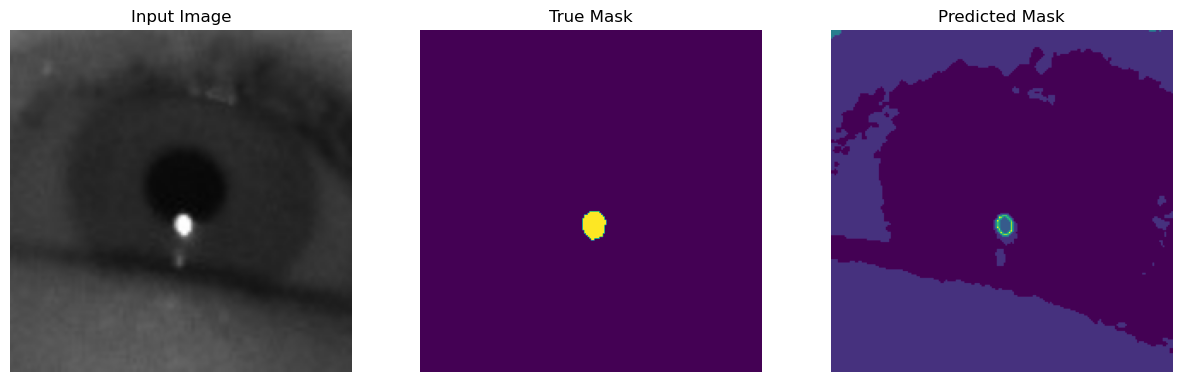

In [28]:
display([images[1], masks[1],db])

In [47]:
def k_means(data,n_clusters,algorithm):
    print(f"Начало выполнения k_means с параметрами n_clusters={n_clusters}, algorithm={algorithm}")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, algorithm=algorithm, n_init=50).fit(data)
    labels = kmeans.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print("Оцененное количество кластеров: %d" % n_clusters)
    print("Оцененное количество выбросов: %d" % n_noise)

    labeled_img = labels.reshape(200,200)
    return labeled_img

In [49]:
def objective(trial):
    n_clusters = trial.suggest_int('n_clusters', 10, 25)
    algorithm=trial.suggest_categorical('algorithm', ["lloyd", "elkan", "auto", "full"])

    db = k_means(img_3f,n_clusters=n_clusters, algorithm=algorithm)

    # Calculate accuracy using accuracy_IoU_scorer function
    accuracy, _ = accuracy_IoU_scorer(db, mask)
    
    return accuracy

for i in range(n):
    img_3f = images[i].reshape((-1, 3))
    mask=masks[i]
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)
    best_trial = study.best_trial
    n_clusters = best_trial.params['n_clusters']
    algorithm = best_trial.params['algorithm']
    bestParamDBscan = k_means(img_3f,n_clusters=n_clusters, algorithm=algorithm)
    accuracy, slice_ = accuracy_IoU_scorer(bestParamDBscan, masks[i])
    print(accuracy)
    directory = 'out/images/imagesKMeans/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open('out/images/imagesKMeans.txt', "a") as f:
        f.write(uniq_img_names[i] + ' ' + str(accuracy) + ' ' + str(n_clusters)+ ' ' + str(algorithm) + '\n')
        f.close()

    data_2d = slice_.reshape((-1, slice_.shape[-1]))
    np.savetxt('out/images/imagesKMeans/' + (uniq_img_names[i]) + '.txt', data_2d, delimiter=',')

[I 2023-06-29 04:59:12,359] A new study created in memory with name: no-name-1ea059e5-e8d2-4045-87cc-4213736c2c4f
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Начало выполнения k_means с параметрами n_clusters=13, algorithm=auto


[I 2023-06-29 04:59:15,453] Trial 0 finished with value: 0.23880597014925373 and parameters: {'n_clusters': 13, 'algorithm': 'auto'}. Best is trial 0 with value: 0.23880597014925373.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=20, algorithm=lloyd


[I 2023-06-29 04:59:19,357] Trial 1 finished with value: 0.1791044776119403 and parameters: {'n_clusters': 20, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.23880597014925373.


Оцененное количество кластеров: 20
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 04:59:23,201] Trial 2 finished with value: 0.23880597014925373 and parameters: {'n_clusters': 16, 'algorithm': 'auto'}. Best is trial 0 with value: 0.23880597014925373.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=23, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 04:59:28,034] Trial 3 finished with value: 0.1791044776119403 and parameters: {'n_clusters': 23, 'algorithm': 'auto'}. Best is trial 0 with value: 0.23880597014925373.


Оцененное количество кластеров: 23
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=20, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 04:59:32,137] Trial 4 finished with value: 0.1791044776119403 and parameters: {'n_clusters': 20, 'algorithm': 'full'}. Best is trial 0 with value: 0.23880597014925373.


Оцененное количество кластеров: 20
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=elkan


[I 2023-06-29 04:59:34,242] Trial 5 finished with value: 0.23880597014925373 and parameters: {'n_clusters': 13, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.23880597014925373.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 04:59:37,696] Trial 6 finished with value: 0.2537313432835821 and parameters: {'n_clusters': 15, 'algorithm': 'full'}. Best is trial 6 with value: 0.2537313432835821.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 04:59:40,919] Trial 7 finished with value: 0.2537313432835821 and parameters: {'n_clusters': 15, 'algorithm': 'auto'}. Best is trial 6 with value: 0.2537313432835821.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 04:59:44,233] Trial 8 finished with value: 0.23880597014925373 and parameters: {'n_clusters': 14, 'algorithm': 'auto'}. Best is trial 6 with value: 0.2537313432835821.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 04:59:47,177] Trial 9 finished with value: 0.291044776119403 and parameters: {'n_clusters': 10, 'algorithm': 'auto'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 04:59:49,108] Trial 10 finished with value: 0.291044776119403 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 04:59:50,954] Trial 11 finished with value: 0.291044776119403 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 04:59:52,913] Trial 12 finished with value: 0.291044776119403 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=lloyd


[I 2023-06-29 04:59:55,918] Trial 13 finished with value: 0.291044776119403 and parameters: {'n_clusters': 11, 'algorithm': 'lloyd'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 04:59:57,998] Trial 14 finished with value: 0.2537313432835821 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=18, algorithm=elkan


[I 2023-06-29 05:00:00,696] Trial 15 finished with value: 0.2537313432835821 and parameters: {'n_clusters': 18, 'algorithm': 'elkan'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 18
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:00:03,606] Trial 16 finished with value: 0.291044776119403 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=25, algorithm=lloyd


[I 2023-06-29 05:00:08,529] Trial 17 finished with value: 0.1791044776119403 and parameters: {'n_clusters': 25, 'algorithm': 'lloyd'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 25
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=17, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:00:12,148] Trial 18 finished with value: 0.23880597014925373 and parameters: {'n_clusters': 17, 'algorithm': 'auto'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 17
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:00:14,140] Trial 19 finished with value: 0.2537313432835821 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=19, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:00:17,986] Trial 20 finished with value: 0.1791044776119403 and parameters: {'n_clusters': 19, 'algorithm': 'auto'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 19
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 05:00:19,838] Trial 21 finished with value: 0.291044776119403 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:00:21,967] Trial 22 finished with value: 0.2537313432835821 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=elkan


[I 2023-06-29 05:00:24,030] Trial 23 finished with value: 0.291044776119403 and parameters: {'n_clusters': 11, 'algorithm': 'elkan'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 05:00:26,036] Trial 24 finished with value: 0.291044776119403 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=elkan


[I 2023-06-29 05:00:28,218] Trial 25 finished with value: 0.23880597014925373 and parameters: {'n_clusters': 13, 'algorithm': 'elkan'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=lloyd


[I 2023-06-29 05:00:31,294] Trial 26 finished with value: 0.291044776119403 and parameters: {'n_clusters': 11, 'algorithm': 'lloyd'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:00:34,406] Trial 27 finished with value: 0.23880597014925373 and parameters: {'n_clusters': 14, 'algorithm': 'full'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=22, algorithm=elkan


[I 2023-06-29 05:00:38,169] Trial 28 finished with value: 0.1791044776119403 and parameters: {'n_clusters': 22, 'algorithm': 'elkan'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 22
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:00:41,285] Trial 29 finished with value: 0.23880597014925373 and parameters: {'n_clusters': 13, 'algorithm': 'auto'}. Best is trial 9 with value: 0.291044776119403.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
0.291044776119403


[I 2023-06-29 05:00:44,341] A new study created in memory with name: no-name-8fa51712-bde1-425b-a5a8-526843849979


Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:00:47,075] Trial 0 finished with value: 0.4725274725274725 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=20, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:00:50,992] Trial 1 finished with value: 0.3131868131868132 and parameters: {'n_clusters': 20, 'algorithm': 'full'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 20
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=22, algorithm=elkan


[I 2023-06-29 05:00:54,801] Trial 2 finished with value: 0.24725274725274726 and parameters: {'n_clusters': 22, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 22
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=22, algorithm=lloyd


[I 2023-06-29 05:00:59,587] Trial 3 finished with value: 0.3241758241758242 and parameters: {'n_clusters': 22, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 22
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:01:02,337] Trial 4 finished with value: 0.4725274725274725 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=22, algorithm=elkan


[I 2023-06-29 05:01:06,284] Trial 5 finished with value: 0.24725274725274726 and parameters: {'n_clusters': 22, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 22
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=elkan


[I 2023-06-29 05:01:08,695] Trial 6 finished with value: 0.3241758241758242 and parameters: {'n_clusters': 15, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=21, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:01:13,149] Trial 7 finished with value: 0.3241758241758242 and parameters: {'n_clusters': 21, 'algorithm': 'full'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 21
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=18, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:01:16,687] Trial 8 finished with value: 0.3131868131868132 and parameters: {'n_clusters': 18, 'algorithm': 'full'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 18
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=19, algorithm=elkan


[I 2023-06-29 05:01:19,880] Trial 9 finished with value: 0.3241758241758242 and parameters: {'n_clusters': 19, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 19
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:01:22,739] Trial 10 finished with value: 0.4725274725274725 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:01:25,573] Trial 11 finished with value: 0.4725274725274725 and parameters: {'n_clusters': 10, 'algorithm': 'auto'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=lloyd


[I 2023-06-29 05:01:28,665] Trial 12 finished with value: 0.3901098901098901 and parameters: {'n_clusters': 13, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=25, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:01:33,724] Trial 13 finished with value: 0.24725274725274726 and parameters: {'n_clusters': 25, 'algorithm': 'auto'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 25
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=lloyd


[I 2023-06-29 05:01:36,736] Trial 14 finished with value: 0.3901098901098901 and parameters: {'n_clusters': 13, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:01:39,849] Trial 15 finished with value: 0.3901098901098901 and parameters: {'n_clusters': 13, 'algorithm': 'full'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:01:43,221] Trial 16 finished with value: 0.3241758241758242 and parameters: {'n_clusters': 16, 'algorithm': 'full'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=lloyd


[I 2023-06-29 05:01:46,210] Trial 17 finished with value: 0.3901098901098901 and parameters: {'n_clusters': 11, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:01:49,097] Trial 18 finished with value: 0.3791208791208791 and parameters: {'n_clusters': 12, 'algorithm': 'auto'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=lloyd


[I 2023-06-29 05:01:52,488] Trial 19 finished with value: 0.3131868131868132 and parameters: {'n_clusters': 15, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:01:55,794] Trial 20 finished with value: 0.3131868131868132 and parameters: {'n_clusters': 15, 'algorithm': 'full'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:01:58,681] Trial 21 finished with value: 0.4725274725274725 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=lloyd


[I 2023-06-29 05:02:01,833] Trial 22 finished with value: 0.3901098901098901 and parameters: {'n_clusters': 11, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:02:04,775] Trial 23 finished with value: 0.4725274725274725 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=lloyd


[I 2023-06-29 05:02:07,890] Trial 24 finished with value: 0.3791208791208791 and parameters: {'n_clusters': 12, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=lloyd


[I 2023-06-29 05:02:10,985] Trial 25 finished with value: 0.3791208791208791 and parameters: {'n_clusters': 12, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:02:13,923] Trial 26 finished with value: 0.3901098901098901 and parameters: {'n_clusters': 11, 'algorithm': 'full'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:02:17,496] Trial 27 finished with value: 0.3241758241758242 and parameters: {'n_clusters': 14, 'algorithm': 'auto'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:02:20,556] Trial 28 finished with value: 0.4725274725274725 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:02:24,461] Trial 29 finished with value: 0.3241758241758242 and parameters: {'n_clusters': 16, 'algorithm': 'full'}. Best is trial 0 with value: 0.4725274725274725.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:02:27,575] A new study created in memory with name: no-name-84e86b18-ba87-4c30-a74f-4decf975c0e7


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
0.4725274725274725
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:02:30,723] Trial 0 finished with value: 0.38764044943820225 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=23, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:02:35,540] Trial 1 finished with value: 0.20786516853932585 and parameters: {'n_clusters': 23, 'algorithm': 'auto'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 23
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=22, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:02:40,292] Trial 2 finished with value: 0.20786516853932585 and parameters: {'n_clusters': 22, 'algorithm': 'auto'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 22
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=elkan


[I 2023-06-29 05:02:43,124] Trial 3 finished with value: 0.33146067415730335 and parameters: {'n_clusters': 15, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 05:02:45,147] Trial 4 finished with value: 0.38764044943820225 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=24, algorithm=elkan


[I 2023-06-29 05:02:49,337] Trial 5 finished with value: 0.20786516853932585 and parameters: {'n_clusters': 24, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 24
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:02:52,782] Trial 6 finished with value: 0.33146067415730335 and parameters: {'n_clusters': 14, 'algorithm': 'full'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=lloyd


[I 2023-06-29 05:02:56,268] Trial 7 finished with value: 0.33146067415730335 and parameters: {'n_clusters': 15, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=elkan


[I 2023-06-29 05:02:58,702] Trial 8 finished with value: 0.34831460674157305 and parameters: {'n_clusters': 13, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=17, algorithm=elkan


[I 2023-06-29 05:03:01,490] Trial 9 finished with value: 0.3258426966292135 and parameters: {'n_clusters': 17, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 17
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:03:04,438] Trial 10 finished with value: 0.38764044943820225 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:03:07,376] Trial 11 finished with value: 0.38764044943820225 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:03:10,458] Trial 12 finished with value: 0.3595505617977528 and parameters: {'n_clusters': 11, 'algorithm': 'full'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=19, algorithm=lloyd


[I 2023-06-29 05:03:14,318] Trial 13 finished with value: 0.20786516853932585 and parameters: {'n_clusters': 19, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 19
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:03:16,658] Trial 14 finished with value: 0.38764044943820225 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=18, algorithm=lloyd


[I 2023-06-29 05:03:20,680] Trial 15 finished with value: 0.20786516853932585 and parameters: {'n_clusters': 18, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 18
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=20, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:03:25,261] Trial 16 finished with value: 0.20786516853932585 and parameters: {'n_clusters': 20, 'algorithm': 'auto'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 20
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:03:28,374] Trial 17 finished with value: 0.38764044943820225 and parameters: {'n_clusters': 12, 'algorithm': 'full'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=elkan


[I 2023-06-29 05:03:31,228] Trial 18 finished with value: 0.33146067415730335 and parameters: {'n_clusters': 16, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=lloyd


[I 2023-06-29 05:03:34,417] Trial 19 finished with value: 0.34831460674157305 and parameters: {'n_clusters': 13, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 05:03:36,484] Trial 20 finished with value: 0.38764044943820225 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:03:39,406] Trial 21 finished with value: 0.38764044943820225 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=lloyd


[I 2023-06-29 05:03:42,501] Trial 22 finished with value: 0.38764044943820225 and parameters: {'n_clusters': 12, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=lloyd


[I 2023-06-29 05:03:45,443] Trial 23 finished with value: 0.3595505617977528 and parameters: {'n_clusters': 11, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:03:48,328] Trial 24 finished with value: 0.38764044943820225 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=lloyd


[I 2023-06-29 05:03:51,647] Trial 25 finished with value: 0.33146067415730335 and parameters: {'n_clusters': 14, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:03:54,701] Trial 26 finished with value: 0.3595505617977528 and parameters: {'n_clusters': 11, 'algorithm': 'auto'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:03:57,829] Trial 27 finished with value: 0.34831460674157305 and parameters: {'n_clusters': 13, 'algorithm': 'full'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=21, algorithm=lloyd


[I 2023-06-29 05:04:02,337] Trial 28 finished with value: 0.20786516853932585 and parameters: {'n_clusters': 21, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 21
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=25, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:04:07,332] Trial 29 finished with value: 0.20786516853932585 and parameters: {'n_clusters': 25, 'algorithm': 'auto'}. Best is trial 0 with value: 0.38764044943820225.


Оцененное количество кластеров: 25
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:04:10,466] A new study created in memory with name: no-name-38e12275-bb10-4496-8dd7-42db9b90a09d


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
0.38764044943820225
Начало выполнения k_means с параметрами n_clusters=15, algorithm=elkan


[I 2023-06-29 05:04:12,696] Trial 0 finished with value: 0.2318840579710145 and parameters: {'n_clusters': 15, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.2318840579710145.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:04:15,878] Trial 1 finished with value: 0.2463768115942029 and parameters: {'n_clusters': 14, 'algorithm': 'auto'}. Best is trial 1 with value: 0.2463768115942029.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=lloyd


[I 2023-06-29 05:04:19,251] Trial 2 finished with value: 0.2318840579710145 and parameters: {'n_clusters': 16, 'algorithm': 'lloyd'}. Best is trial 1 with value: 0.2463768115942029.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:04:22,191] Trial 3 finished with value: 0.2898550724637681 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=17, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:04:25,890] Trial 4 finished with value: 0.2318840579710145 and parameters: {'n_clusters': 17, 'algorithm': 'auto'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 17
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=22, algorithm=elkan


[I 2023-06-29 05:04:29,718] Trial 5 finished with value: 0.2028985507246377 and parameters: {'n_clusters': 22, 'algorithm': 'elkan'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 22
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=25, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:04:34,814] Trial 6 finished with value: 0.2028985507246377 and parameters: {'n_clusters': 25, 'algorithm': 'auto'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 25
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:04:37,666] Trial 7 finished with value: 0.2898550724637681 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=lloyd


[I 2023-06-29 05:04:41,118] Trial 8 finished with value: 0.2318840579710145 and parameters: {'n_clusters': 16, 'algorithm': 'lloyd'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=lloyd


[I 2023-06-29 05:04:44,572] Trial 9 finished with value: 0.2318840579710145 and parameters: {'n_clusters': 16, 'algorithm': 'lloyd'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:04:47,271] Trial 10 finished with value: 0.2898550724637681 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:04:50,045] Trial 11 finished with value: 0.2898550724637681 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:04:52,951] Trial 12 finished with value: 0.2463768115942029 and parameters: {'n_clusters': 12, 'algorithm': 'full'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=20, algorithm=lloyd


[I 2023-06-29 05:04:56,969] Trial 13 finished with value: 0.2028985507246377 and parameters: {'n_clusters': 20, 'algorithm': 'lloyd'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 20
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:04:59,866] Trial 14 finished with value: 0.2463768115942029 and parameters: {'n_clusters': 12, 'algorithm': 'full'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:05:02,943] Trial 15 finished with value: 0.2463768115942029 and parameters: {'n_clusters': 13, 'algorithm': 'full'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=19, algorithm=lloyd


[I 2023-06-29 05:05:06,627] Trial 16 finished with value: 0.2318840579710145 and parameters: {'n_clusters': 19, 'algorithm': 'lloyd'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 19
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 05:05:08,353] Trial 17 finished with value: 0.2898550724637681 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=lloyd


[I 2023-06-29 05:05:11,276] Trial 18 finished with value: 0.2463768115942029 and parameters: {'n_clusters': 12, 'algorithm': 'lloyd'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:05:14,385] Trial 19 finished with value: 0.2463768115942029 and parameters: {'n_clusters': 11, 'algorithm': 'full'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=lloyd


[I 2023-06-29 05:05:17,671] Trial 20 finished with value: 0.2463768115942029 and parameters: {'n_clusters': 14, 'algorithm': 'lloyd'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:05:20,658] Trial 21 finished with value: 0.2898550724637681 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:05:23,492] Trial 22 finished with value: 0.2898550724637681 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:05:26,624] Trial 23 finished with value: 0.2463768115942029 and parameters: {'n_clusters': 12, 'algorithm': 'full'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:05:29,932] Trial 24 finished with value: 0.2463768115942029 and parameters: {'n_clusters': 13, 'algorithm': 'full'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:05:32,879] Trial 25 finished with value: 0.2463768115942029 and parameters: {'n_clusters': 11, 'algorithm': 'full'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:05:36,063] Trial 26 finished with value: 0.2463768115942029 and parameters: {'n_clusters': 14, 'algorithm': 'auto'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=elkan


[I 2023-06-29 05:05:37,905] Trial 27 finished with value: 0.2463768115942029 and parameters: {'n_clusters': 11, 'algorithm': 'elkan'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=25, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:05:42,804] Trial 28 finished with value: 0.2028985507246377 and parameters: {'n_clusters': 25, 'algorithm': 'full'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 25
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=23, algorithm=elkan


[I 2023-06-29 05:05:46,825] Trial 29 finished with value: 0.2028985507246377 and parameters: {'n_clusters': 23, 'algorithm': 'elkan'}. Best is trial 3 with value: 0.2898550724637681.


Оцененное количество кластеров: 23
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
0.2898550724637681


[I 2023-06-29 05:05:49,741] A new study created in memory with name: no-name-0c1150cc-488a-4d00-af15-014da8221efa
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Начало выполнения k_means с параметрами n_clusters=20, algorithm=full


[I 2023-06-29 05:05:53,727] Trial 0 finished with value: 0.15897435897435896 and parameters: {'n_clusters': 20, 'algorithm': 'full'}. Best is trial 0 with value: 0.15897435897435896.


Оцененное количество кластеров: 20
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=elkan


[I 2023-06-29 05:05:56,021] Trial 1 finished with value: 0.2358974358974359 and parameters: {'n_clusters': 13, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.2358974358974359.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:05:59,538] Trial 2 finished with value: 0.15897435897435896 and parameters: {'n_clusters': 16, 'algorithm': 'full'}. Best is trial 1 with value: 0.2358974358974359.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=24, algorithm=elkan


[I 2023-06-29 05:06:03,718] Trial 3 finished with value: 0.1076923076923077 and parameters: {'n_clusters': 24, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.2358974358974359.


Оцененное количество кластеров: 24
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=elkan


[I 2023-06-29 05:06:06,169] Trial 4 finished with value: 0.15897435897435896 and parameters: {'n_clusters': 14, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.2358974358974359.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=elkan


[I 2023-06-29 05:06:08,150] Trial 5 finished with value: 0.24102564102564103 and parameters: {'n_clusters': 11, 'algorithm': 'elkan'}. Best is trial 5 with value: 0.24102564102564103.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:06:11,288] Trial 6 finished with value: 0.17435897435897435 and parameters: {'n_clusters': 13, 'algorithm': 'auto'}. Best is trial 5 with value: 0.24102564102564103.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=lloyd


[I 2023-06-29 05:06:14,555] Trial 7 finished with value: 0.16923076923076924 and parameters: {'n_clusters': 15, 'algorithm': 'lloyd'}. Best is trial 5 with value: 0.24102564102564103.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=lloyd


[I 2023-06-29 05:06:18,136] Trial 8 finished with value: 0.16923076923076924 and parameters: {'n_clusters': 15, 'algorithm': 'lloyd'}. Best is trial 5 with value: 0.24102564102564103.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:06:21,776] Trial 9 finished with value: 0.16923076923076924 and parameters: {'n_clusters': 15, 'algorithm': 'auto'}. Best is trial 5 with value: 0.24102564102564103.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=elkan


[I 2023-06-29 05:06:23,976] Trial 10 finished with value: 0.24102564102564103 and parameters: {'n_clusters': 11, 'algorithm': 'elkan'}. Best is trial 5 with value: 0.24102564102564103.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 05:06:25,979] Trial 11 finished with value: 0.24102564102564103 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 5 with value: 0.24102564102564103.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 05:06:27,993] Trial 12 finished with value: 0.24102564102564103 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 5 with value: 0.24102564102564103.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=19, algorithm=elkan


[I 2023-06-29 05:06:31,112] Trial 13 finished with value: 0.15897435897435896 and parameters: {'n_clusters': 19, 'algorithm': 'elkan'}. Best is trial 5 with value: 0.24102564102564103.


Оцененное количество кластеров: 19
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=elkan


[I 2023-06-29 05:06:33,491] Trial 14 finished with value: 0.24102564102564103 and parameters: {'n_clusters': 11, 'algorithm': 'elkan'}. Best is trial 5 with value: 0.24102564102564103.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:06:35,756] Trial 15 finished with value: 0.24615384615384617 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=18, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:06:39,575] Trial 16 finished with value: 0.15897435897435896 and parameters: {'n_clusters': 18, 'algorithm': 'full'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 18
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=lloyd


[I 2023-06-29 05:06:42,669] Trial 17 finished with value: 0.24102564102564103 and parameters: {'n_clusters': 12, 'algorithm': 'lloyd'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=22, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:06:47,394] Trial 18 finished with value: 0.15897435897435896 and parameters: {'n_clusters': 22, 'algorithm': 'auto'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 22
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=17, algorithm=elkan


[I 2023-06-29 05:06:50,337] Trial 19 finished with value: 0.15897435897435896 and parameters: {'n_clusters': 17, 'algorithm': 'elkan'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 17
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=21, algorithm=elkan


[I 2023-06-29 05:06:54,209] Trial 20 finished with value: 0.1641025641025641 and parameters: {'n_clusters': 21, 'algorithm': 'elkan'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 21
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:06:56,444] Trial 21 finished with value: 0.24615384615384617 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:06:58,707] Trial 22 finished with value: 0.24615384615384617 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=elkan


[I 2023-06-29 05:07:00,994] Trial 23 finished with value: 0.2358974358974359 and parameters: {'n_clusters': 13, 'algorithm': 'elkan'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:07:03,313] Trial 24 finished with value: 0.24615384615384617 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=elkan


[I 2023-06-29 05:07:05,784] Trial 25 finished with value: 0.15897435897435896 and parameters: {'n_clusters': 14, 'algorithm': 'elkan'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=17, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:07:09,448] Trial 26 finished with value: 0.15897435897435896 and parameters: {'n_clusters': 17, 'algorithm': 'auto'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 17
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=lloyd


[I 2023-06-29 05:07:12,459] Trial 27 finished with value: 0.24102564102564103 and parameters: {'n_clusters': 12, 'algorithm': 'lloyd'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:07:15,318] Trial 28 finished with value: 0.24102564102564103 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=25, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:07:20,643] Trial 29 finished with value: 0.12307692307692308 and parameters: {'n_clusters': 25, 'algorithm': 'full'}. Best is trial 15 with value: 0.24615384615384617.


Оцененное количество кластеров: 25
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan
Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
0.24615384615384617


[I 2023-06-29 05:07:23,356] A new study created in memory with name: no-name-809f0309-7be6-4130-80ed-0b3d3f35ea70


Начало выполнения k_means с параметрами n_clusters=13, algorithm=elkan


[I 2023-06-29 05:07:25,817] Trial 0 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 13, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=21, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:07:30,323] Trial 1 finished with value: 0.2073170731707317 and parameters: {'n_clusters': 21, 'algorithm': 'full'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 21
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=18, algorithm=elkan


[I 2023-06-29 05:07:33,090] Trial 2 finished with value: 0.34146341463414637 and parameters: {'n_clusters': 18, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 18
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=19, algorithm=elkan


[I 2023-06-29 05:07:36,266] Trial 3 finished with value: 0.32926829268292684 and parameters: {'n_clusters': 19, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 19
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=18, algorithm=lloyd


[I 2023-06-29 05:07:39,867] Trial 4 finished with value: 0.2073170731707317 and parameters: {'n_clusters': 18, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 18
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=elkan


[I 2023-06-29 05:07:42,607] Trial 5 finished with value: 0.32926829268292684 and parameters: {'n_clusters': 16, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=lloyd


[I 2023-06-29 05:07:46,011] Trial 6 finished with value: 0.32926829268292684 and parameters: {'n_clusters': 16, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=19, algorithm=elkan


[I 2023-06-29 05:07:49,165] Trial 7 finished with value: 0.32926829268292684 and parameters: {'n_clusters': 19, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 19
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:07:52,124] Trial 8 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=17, algorithm=elkan


[I 2023-06-29 05:07:55,048] Trial 9 finished with value: 0.32926829268292684 and parameters: {'n_clusters': 17, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 17
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:07:58,028] Trial 10 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 11, 'algorithm': 'auto'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:08:00,966] Trial 11 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:08:04,113] Trial 12 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 13, 'algorithm': 'auto'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=25, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:08:09,343] Trial 13 finished with value: 0.1951219512195122 and parameters: {'n_clusters': 25, 'algorithm': 'full'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 25
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=lloyd


[I 2023-06-29 05:08:12,505] Trial 14 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 13, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=lloyd


[I 2023-06-29 05:08:15,731] Trial 15 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 13, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:08:18,701] Trial 16 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 11, 'algorithm': 'full'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:08:22,214] Trial 17 finished with value: 0.32926829268292684 and parameters: {'n_clusters': 14, 'algorithm': 'auto'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 05:08:24,405] Trial 18 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=lloyd


[I 2023-06-29 05:08:28,027] Trial 19 finished with value: 0.32926829268292684 and parameters: {'n_clusters': 15, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:08:30,163] Trial 20 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:08:33,235] Trial 21 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 11, 'algorithm': 'auto'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:08:36,146] Trial 22 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 10, 'algorithm': 'auto'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:08:39,250] Trial 23 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 12, 'algorithm': 'auto'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:08:42,385] Trial 24 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 12, 'algorithm': 'auto'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:08:45,825] Trial 25 finished with value: 0.32926829268292684 and parameters: {'n_clusters': 15, 'algorithm': 'auto'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=lloyd


[I 2023-06-29 05:08:48,830] Trial 26 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 11, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=22, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:08:53,603] Trial 27 finished with value: 0.2682926829268293 and parameters: {'n_clusters': 22, 'algorithm': 'full'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 22
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=lloyd


[I 2023-06-29 05:08:56,799] Trial 28 finished with value: 0.32926829268292684 and parameters: {'n_clusters': 14, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:08:59,666] Trial 29 finished with value: 0.35365853658536583 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 0 with value: 0.35365853658536583.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=elkan
Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
0.35365853658536583


[I 2023-06-29 05:09:02,127] A new study created in memory with name: no-name-1162ae1a-614e-48ba-b841-46cb0c5e919c


Начало выполнения k_means с параметрами n_clusters=25, algorithm=elkan


[I 2023-06-29 05:09:06,546] Trial 0 finished with value: 0.1595744680851064 and parameters: {'n_clusters': 25, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.1595744680851064.


Оцененное количество кластеров: 25
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=elkan


[I 2023-06-29 05:09:08,959] Trial 1 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 14, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=24, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:09:13,963] Trial 2 finished with value: 0.1595744680851064 and parameters: {'n_clusters': 24, 'algorithm': 'auto'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 24
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:09:17,246] Trial 3 finished with value: 0.1595744680851064 and parameters: {'n_clusters': 15, 'algorithm': 'full'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=19, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:09:21,315] Trial 4 finished with value: 0.1595744680851064 and parameters: {'n_clusters': 19, 'algorithm': 'full'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 19
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=19, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:09:25,288] Trial 5 finished with value: 0.1595744680851064 and parameters: {'n_clusters': 19, 'algorithm': 'full'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 19
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=23, algorithm=elkan


[I 2023-06-29 05:09:29,581] Trial 6 finished with value: 0.1595744680851064 and parameters: {'n_clusters': 23, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 23
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=elkan


[I 2023-06-29 05:09:31,647] Trial 7 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 11, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=elkan


[I 2023-06-29 05:09:34,443] Trial 8 finished with value: 0.1595744680851064 and parameters: {'n_clusters': 16, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:09:37,767] Trial 9 finished with value: 0.1595744680851064 and parameters: {'n_clusters': 15, 'algorithm': 'auto'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:09:40,610] Trial 10 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 05:09:42,535] Trial 11 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:09:44,841] Trial 12 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=elkan


[I 2023-06-29 05:09:47,171] Trial 13 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 13, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=lloyd


[I 2023-06-29 05:09:50,333] Trial 14 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 13, 'algorithm': 'lloyd'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:09:52,521] Trial 15 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=17, algorithm=elkan


[I 2023-06-29 05:09:55,380] Trial 16 finished with value: 0.1595744680851064 and parameters: {'n_clusters': 17, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 17
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=19, algorithm=lloyd


[I 2023-06-29 05:09:59,194] Trial 17 finished with value: 0.1595744680851064 and parameters: {'n_clusters': 19, 'algorithm': 'lloyd'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 19
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:10:02,617] Trial 18 finished with value: 0.1702127659574468 and parameters: {'n_clusters': 14, 'algorithm': 'auto'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=elkan


[I 2023-06-29 05:10:04,666] Trial 19 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 11, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=21, algorithm=elkan


[I 2023-06-29 05:10:08,540] Trial 20 finished with value: 0.1595744680851064 and parameters: {'n_clusters': 21, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 21
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:10:11,345] Trial 21 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:10:14,185] Trial 22 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=lloyd


[I 2023-06-29 05:10:17,375] Trial 23 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 13, 'algorithm': 'lloyd'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=lloyd


[I 2023-06-29 05:10:20,564] Trial 24 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 11, 'algorithm': 'lloyd'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=lloyd


[I 2023-06-29 05:10:23,843] Trial 25 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 12, 'algorithm': 'lloyd'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:10:26,837] Trial 26 finished with value: 0.30851063829787234 and parameters: {'n_clusters': 11, 'algorithm': 'full'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:10:30,027] Trial 27 finished with value: 0.1702127659574468 and parameters: {'n_clusters': 14, 'algorithm': 'auto'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=17, algorithm=elkan


[I 2023-06-29 05:10:32,896] Trial 28 finished with value: 0.1595744680851064 and parameters: {'n_clusters': 17, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 17
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=elkan


[I 2023-06-29 05:10:35,434] Trial 29 finished with value: 0.1595744680851064 and parameters: {'n_clusters': 15, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.30851063829787234.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=elkan
Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
0.30851063829787234


[I 2023-06-29 05:10:38,107] A new study created in memory with name: no-name-61761fde-532a-4ebe-a680-3561f6278957
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Начало выполнения k_means с параметрами n_clusters=25, algorithm=auto


[I 2023-06-29 05:10:43,251] Trial 0 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 25, 'algorithm': 'auto'}. Best is trial 0 with value: 0.20202020202020202.


Оцененное количество кластеров: 25
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=18, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:10:47,054] Trial 1 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 18, 'algorithm': 'auto'}. Best is trial 0 with value: 0.20202020202020202.


Оцененное количество кластеров: 18
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:10:49,984] Trial 2 finished with value: 0.40404040404040403 and parameters: {'n_clusters': 10, 'algorithm': 'auto'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=23, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:10:54,982] Trial 3 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 23, 'algorithm': 'auto'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 23
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:10:58,110] Trial 4 finished with value: 0.26262626262626265 and parameters: {'n_clusters': 13, 'algorithm': 'full'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=20, algorithm=lloyd


[I 2023-06-29 05:11:02,137] Trial 5 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 20, 'algorithm': 'lloyd'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 20
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:11:05,160] Trial 6 finished with value: 0.26262626262626265 and parameters: {'n_clusters': 12, 'algorithm': 'auto'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:11:08,017] Trial 7 finished with value: 0.40404040404040403 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=20, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:11:12,182] Trial 8 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 20, 'algorithm': 'full'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 20
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:11:15,124] Trial 9 finished with value: 0.26262626262626265 and parameters: {'n_clusters': 11, 'algorithm': 'full'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=elkan


[I 2023-06-29 05:11:17,749] Trial 10 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 15, 'algorithm': 'elkan'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 05:11:19,657] Trial 11 finished with value: 0.40404040404040403 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=lloyd


[I 2023-06-29 05:11:23,645] Trial 12 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 15, 'algorithm': 'lloyd'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:11:27,183] Trial 13 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 14, 'algorithm': 'full'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:11:30,000] Trial 14 finished with value: 0.40404040404040403 and parameters: {'n_clusters': 10, 'algorithm': 'auto'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:11:33,573] Trial 15 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 16, 'algorithm': 'full'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:11:35,605] Trial 16 finished with value: 0.26262626262626265 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=17, algorithm=lloyd


[I 2023-06-29 05:11:39,443] Trial 17 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 17, 'algorithm': 'lloyd'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 17
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:11:42,249] Trial 18 finished with value: 0.40404040404040403 and parameters: {'n_clusters': 10, 'algorithm': 'auto'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:11:45,515] Trial 19 finished with value: 0.26262626262626265 and parameters: {'n_clusters': 13, 'algorithm': 'full'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=19, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:11:49,369] Trial 20 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 19, 'algorithm': 'auto'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 19
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 05:11:51,168] Trial 21 finished with value: 0.40404040404040403 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:11:53,270] Trial 22 finished with value: 0.26262626262626265 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=elkan


[I 2023-06-29 05:11:55,289] Trial 23 finished with value: 0.26262626262626265 and parameters: {'n_clusters': 11, 'algorithm': 'elkan'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 05:11:57,005] Trial 24 finished with value: 0.40404040404040403 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=elkan


[I 2023-06-29 05:11:59,241] Trial 25 finished with value: 0.26262626262626265 and parameters: {'n_clusters': 13, 'algorithm': 'elkan'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:12:02,110] Trial 26 finished with value: 0.26262626262626265 and parameters: {'n_clusters': 11, 'algorithm': 'full'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=lloyd


[I 2023-06-29 05:12:05,382] Trial 27 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 14, 'algorithm': 'lloyd'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=22, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:12:10,113] Trial 28 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 22, 'algorithm': 'auto'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 22
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=25, algorithm=elkan


[I 2023-06-29 05:12:14,564] Trial 29 finished with value: 0.20202020202020202 and parameters: {'n_clusters': 25, 'algorithm': 'elkan'}. Best is trial 2 with value: 0.40404040404040403.


Оцененное количество кластеров: 25
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
0.40404040404040403


[I 2023-06-29 05:12:17,795] A new study created in memory with name: no-name-f502e188-0c8a-4607-a503-cf52e2de9d17


Начало выполнения k_means с параметрами n_clusters=13, algorithm=elkan


[I 2023-06-29 05:12:20,080] Trial 0 finished with value: 0.2702702702702703 and parameters: {'n_clusters': 13, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.2702702702702703.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=lloyd


[I 2023-06-29 05:12:24,016] Trial 1 finished with value: 0.1891891891891892 and parameters: {'n_clusters': 16, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.2702702702702703.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=17, algorithm=elkan


[I 2023-06-29 05:12:27,053] Trial 2 finished with value: 0.1891891891891892 and parameters: {'n_clusters': 17, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.2702702702702703.


Оцененное количество кластеров: 17
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:12:29,969] Trial 3 finished with value: 0.2702702702702703 and parameters: {'n_clusters': 10, 'algorithm': 'auto'}. Best is trial 0 with value: 0.2702702702702703.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=19, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:12:34,074] Trial 4 finished with value: 0.17567567567567569 and parameters: {'n_clusters': 19, 'algorithm': 'auto'}. Best is trial 0 with value: 0.2702702702702703.


Оцененное количество кластеров: 19
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=elkan


[I 2023-06-29 05:12:36,552] Trial 5 finished with value: 0.1891891891891892 and parameters: {'n_clusters': 16, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.2702702702702703.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=23, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:12:41,673] Trial 6 finished with value: 0.1891891891891892 and parameters: {'n_clusters': 23, 'algorithm': 'auto'}. Best is trial 0 with value: 0.2702702702702703.


Оцененное количество кластеров: 23
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:12:44,860] Trial 7 finished with value: 0.1891891891891892 and parameters: {'n_clusters': 14, 'algorithm': 'full'}. Best is trial 0 with value: 0.2702702702702703.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:12:48,331] Trial 8 finished with value: 0.1891891891891892 and parameters: {'n_clusters': 16, 'algorithm': 'full'}. Best is trial 0 with value: 0.2702702702702703.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:12:52,079] Trial 9 finished with value: 0.1891891891891892 and parameters: {'n_clusters': 16, 'algorithm': 'full'}. Best is trial 0 with value: 0.2702702702702703.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=elkan


[I 2023-06-29 05:12:53,846] Trial 10 finished with value: 0.2702702702702703 and parameters: {'n_clusters': 10, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.2702702702702703.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:12:56,818] Trial 11 finished with value: 0.2702702702702703 and parameters: {'n_clusters': 10, 'algorithm': 'auto'}. Best is trial 0 with value: 0.2702702702702703.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=lloyd


[I 2023-06-29 05:13:00,011] Trial 12 finished with value: 0.28378378378378377 and parameters: {'n_clusters': 12, 'algorithm': 'lloyd'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=lloyd


[I 2023-06-29 05:13:03,121] Trial 13 finished with value: 0.2702702702702703 and parameters: {'n_clusters': 13, 'algorithm': 'lloyd'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=lloyd


[I 2023-06-29 05:13:06,233] Trial 14 finished with value: 0.2702702702702703 and parameters: {'n_clusters': 13, 'algorithm': 'lloyd'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=20, algorithm=lloyd


[I 2023-06-29 05:13:10,109] Trial 15 finished with value: 0.1891891891891892 and parameters: {'n_clusters': 20, 'algorithm': 'lloyd'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 20
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:13:12,102] Trial 16 finished with value: 0.28378378378378377 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=25, algorithm=elkan


[I 2023-06-29 05:13:16,223] Trial 17 finished with value: 0.10810810810810811 and parameters: {'n_clusters': 25, 'algorithm': 'elkan'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 25
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=lloyd


[I 2023-06-29 05:13:19,249] Trial 18 finished with value: 0.28378378378378377 and parameters: {'n_clusters': 12, 'algorithm': 'lloyd'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=elkan


[I 2023-06-29 05:13:21,341] Trial 19 finished with value: 0.28378378378378377 and parameters: {'n_clusters': 12, 'algorithm': 'elkan'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=20, algorithm=lloyd


[I 2023-06-29 05:13:25,433] Trial 20 finished with value: 0.1891891891891892 and parameters: {'n_clusters': 20, 'algorithm': 'lloyd'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 20
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=lloyd


[I 2023-06-29 05:13:28,361] Trial 21 finished with value: 0.28378378378378377 and parameters: {'n_clusters': 12, 'algorithm': 'lloyd'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=lloyd


[I 2023-06-29 05:13:31,602] Trial 22 finished with value: 0.1891891891891892 and parameters: {'n_clusters': 14, 'algorithm': 'lloyd'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=lloyd


[I 2023-06-29 05:13:34,414] Trial 23 finished with value: 0.2702702702702703 and parameters: {'n_clusters': 11, 'algorithm': 'lloyd'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=lloyd


[I 2023-06-29 05:13:37,581] Trial 24 finished with value: 0.1891891891891892 and parameters: {'n_clusters': 14, 'algorithm': 'lloyd'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=lloyd


[I 2023-06-29 05:13:40,459] Trial 25 finished with value: 0.28378378378378377 and parameters: {'n_clusters': 12, 'algorithm': 'lloyd'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=elkan


[I 2023-06-29 05:13:42,354] Trial 26 finished with value: 0.2702702702702703 and parameters: {'n_clusters': 11, 'algorithm': 'elkan'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:13:45,696] Trial 27 finished with value: 0.1891891891891892 and parameters: {'n_clusters': 15, 'algorithm': 'full'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=18, algorithm=lloyd


[I 2023-06-29 05:13:49,391] Trial 28 finished with value: 0.17567567567567569 and parameters: {'n_clusters': 18, 'algorithm': 'lloyd'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 18
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=elkan


[I 2023-06-29 05:13:51,258] Trial 29 finished with value: 0.2702702702702703 and parameters: {'n_clusters': 11, 'algorithm': 'elkan'}. Best is trial 12 with value: 0.28378378378378377.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=lloyd
Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
0.28378378378378377


[I 2023-06-29 05:13:54,436] A new study created in memory with name: no-name-40b2adf5-8d04-45b3-ace8-0b4934148db4
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Начало выполнения k_means с параметрами n_clusters=16, algorithm=auto


[I 2023-06-29 05:13:57,825] Trial 0 finished with value: 0.32608695652173914 and parameters: {'n_clusters': 16, 'algorithm': 'auto'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=elkan


[I 2023-06-29 05:14:00,259] Trial 1 finished with value: 0.2536231884057971 and parameters: {'n_clusters': 15, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:14:03,379] Trial 2 finished with value: 0.3188405797101449 and parameters: {'n_clusters': 13, 'algorithm': 'auto'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=elkan


[I 2023-06-29 05:14:05,331] Trial 3 finished with value: 0.2536231884057971 and parameters: {'n_clusters': 11, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=18, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:14:08,943] Trial 4 finished with value: 0.2246376811594203 and parameters: {'n_clusters': 18, 'algorithm': 'full'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 18
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=19, algorithm=elkan


[I 2023-06-29 05:14:12,023] Trial 5 finished with value: 0.2246376811594203 and parameters: {'n_clusters': 19, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 19
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=21, algorithm=lloyd


[I 2023-06-29 05:14:16,417] Trial 6 finished with value: 0.2246376811594203 and parameters: {'n_clusters': 21, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 21
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=lloyd


[I 2023-06-29 05:14:20,014] Trial 7 finished with value: 0.32608695652173914 and parameters: {'n_clusters': 16, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=18, algorithm=lloyd


[I 2023-06-29 05:14:24,101] Trial 8 finished with value: 0.2246376811594203 and parameters: {'n_clusters': 18, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 18
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:14:27,484] Trial 9 finished with value: 0.3188405797101449 and parameters: {'n_clusters': 13, 'algorithm': 'auto'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=25, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:14:32,479] Trial 10 finished with value: 0.2246376811594203 and parameters: {'n_clusters': 25, 'algorithm': 'auto'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 25
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=lloyd


[I 2023-06-29 05:14:35,861] Trial 11 finished with value: 0.2536231884057971 and parameters: {'n_clusters': 15, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=21, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:14:40,225] Trial 12 finished with value: 0.2246376811594203 and parameters: {'n_clusters': 21, 'algorithm': 'full'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 21
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=15, algorithm=lloyd


[I 2023-06-29 05:14:43,587] Trial 13 finished with value: 0.2536231884057971 and parameters: {'n_clusters': 15, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 15
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=16, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:14:46,944] Trial 14 finished with value: 0.32608695652173914 and parameters: {'n_clusters': 16, 'algorithm': 'auto'}. Best is trial 0 with value: 0.32608695652173914.


Оцененное количество кластеров: 16
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:14:49,773] Trial 15 finished with value: 0.42028985507246375 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:14:52,657] Trial 16 finished with value: 0.32608695652173914 and parameters: {'n_clusters': 11, 'algorithm': 'auto'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:14:55,445] Trial 17 finished with value: 0.42028985507246375 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:14:58,186] Trial 18 finished with value: 0.42028985507246375 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:15:01,250] Trial 19 finished with value: 0.32608695652173914 and parameters: {'n_clusters': 12, 'algorithm': 'full'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:15:04,010] Trial 20 finished with value: 0.42028985507246375 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:15:06,850] Trial 21 finished with value: 0.42028985507246375 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=13, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:15:09,964] Trial 22 finished with value: 0.3188405797101449 and parameters: {'n_clusters': 13, 'algorithm': 'full'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 13
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:15:12,729] Trial 23 finished with value: 0.42028985507246375 and parameters: {'n_clusters': 10, 'algorithm': 'full'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:15:15,684] Trial 24 finished with value: 0.32608695652173914 and parameters: {'n_clusters': 12, 'algorithm': 'full'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=12, algorithm=lloyd


[I 2023-06-29 05:15:18,759] Trial 25 finished with value: 0.32608695652173914 and parameters: {'n_clusters': 12, 'algorithm': 'lloyd'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 12
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=11, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:15:21,938] Trial 26 finished with value: 0.32608695652173914 and parameters: {'n_clusters': 11, 'algorithm': 'full'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 11
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=14, algorithm=full


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
[I 2023-06-29 05:15:25,358] Trial 27 finished with value: 0.2536231884057971 and parameters: {'n_clusters': 14, 'algorithm': 'full'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 14
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd


[I 2023-06-29 05:15:28,101] Trial 28 finished with value: 0.42028985507246375 and parameters: {'n_clusters': 10, 'algorithm': 'lloyd'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=25, algorithm=elkan


[I 2023-06-29 05:15:32,506] Trial 29 finished with value: 0.2246376811594203 and parameters: {'n_clusters': 25, 'algorithm': 'elkan'}. Best is trial 15 with value: 0.42028985507246375.


Оцененное количество кластеров: 25
Оцененное количество выбросов: 0
Начало выполнения k_means с параметрами n_clusters=10, algorithm=lloyd
Оцененное количество кластеров: 10
Оцененное количество выбросов: 0
0.42028985507246375


Начало выполнения k_means с параметрами n_clusters=10, algorithm=auto


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Оцененное количество кластеров: 10
Оцененное количество выбросов: 0


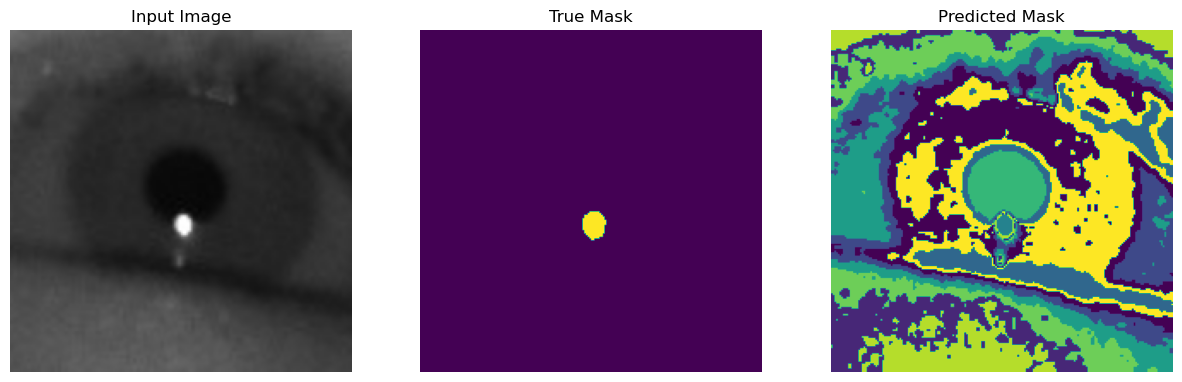

0.33624454148471616


In [40]:
img_3f = images[1].reshape((-1, 3))
db = k_means(img_3f,n_clusters=10, algorithm="auto")
display([images[1], masks[1],db])
accuracy, slice_ = accuracy_IoU_scorer(bestParamDBscan, masks[1])
print(accuracy)